# Data Literacy Notebook

Requires data to be loaded from the GCloud bucket.

Required files (in the same directory as this notebook):
- `departure-data-reader-key.json` - GCS service account key
- `trias.py` - TRIAS API client module

Installing dependencies

In [35]:
!pip install google-cloud-storage pandas plotly networkx ipysigma requests -q

# GCloud data loading

## Initialize Google Cloud Storage Client

Sets up authentication using a service account key file and connects to the `departure_data` bucket where all transit data is stored.

In [36]:
import os
import pandas as pd
from google.cloud import storage

# Set the path to your service account key file
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'departure-data-reader-key.json'

# Initialize the storage client
client = storage.Client()
bucket_name = 'departure_data'
bucket = client.get_bucket(bucket_name)

print("Google Cloud Storage client initialized successfully.")

Google Cloud Storage client initialized successfully.


## List Available Data Files

Scans the bucket and filters for departure and trip_calls CSV files. These files contain timestamped snapshots of real-time transit data.

In [37]:
# List all files in the bucket and filter for departure files
blobs_iterator = bucket.list_blobs()
blobs = list(blobs_iterator) # Convert iterator to a list

departure_files = [blob.name for blob in blobs if 'departures' in blob.name and blob.name.endswith('.csv')]
#lines_files = [blob.name for blob in blobs if 'lines' in blob.name and blob.name.endswith('.csv')]
trip_files = [blob.name for blob in blobs if 'trip_calls' in blob.name and blob.name.endswith('.csv')]

print(f"Found {len(departure_files)} departure files")
#print(f"Found {len(lines_files)} lines files")
print(f"Found {len(trip_files)} trip files")

Found 1268 departure files
Found 1268 trip files


## Parallel Data Loading Function

Defines `download_and_combine_data()` which downloads CSV files from GCS in parallel using a thread pool. Extracts timestamps from filenames and combines all data into a single DataFrame.

In [38]:
from concurrent.futures import ThreadPoolExecutor, as_completed
import io, re
import pandas as pd

def download_and_combine_data(file_list, max_workers=20):
    total_files = len(file_list)
    if total_files == 0:
        print("No files to process.")
        return pd.DataFrame()

    print(f"Processing {total_files} files in parallel (max_workers={max_workers})...")

    def _load_single_file(file_name):
        blob = bucket.blob(file_name)
        data = blob.download_as_string()
        df = pd.read_csv(io.BytesIO(data))

        # Extract timestamp from filename and add as a column
        match = re.search(r'(\d{8}_\d{6})', file_name)
        if match:
            timestamp_str = match.group(1)
            df['timestamp'] = pd.to_datetime(timestamp_str, format='%Y%m%d_%H%M%S')
        else:
            df['timestamp'] = pd.NaT

        return df

    dfs = []
    # Use at most total_files workers
    workers = min(max_workers, total_files)

    with ThreadPoolExecutor(max_workers=workers) as executor:
        future_to_file = {
            executor.submit(_load_single_file, file_name): file_name
            for file_name in file_list
        }

        for i, future in enumerate(as_completed(future_to_file), 1):
            file_name = future_to_file[future]
            try:
                df = future.result()
                dfs.append(df)
            except Exception as e:
                # Don't crash everything for one bad file, just log it
                print(f"Error processing {file_name}: {e}")
            if i % 10 == 0 or i == total_files:
                print(f"Processed {i}/{total_files} files...")

    if not dfs:
        print("No dataframes were loaded successfully.")
        return pd.DataFrame()

    combined_data = pd.concat(dfs, ignore_index=True)

    print(f"\nCombined {total_files} files into DataFrame with {len(combined_data)} rows.")
    if 'timestamp' in combined_data.columns:
        print(f"Date range: {combined_data['timestamp'].min()} to {combined_data['timestamp'].max()}")

    return combined_data

## Load Departure Data

Downloads and combines all 1,111 departure files into `all_departure_data`. Each row represents a scheduled departure with planned/estimated times, delays, and weather conditions.

In [39]:
all_departure_data = download_and_combine_data(departure_files)
# Print data
display(all_departure_data.head(10))

Processing 1268 files in parallel (max_workers=20)...
Processed 10/1268 files...
Processed 20/1268 files...
Processed 30/1268 files...
Processed 40/1268 files...
Processed 50/1268 files...
Processed 60/1268 files...
Processed 70/1268 files...
Processed 80/1268 files...
Processed 90/1268 files...
Processed 100/1268 files...
Processed 110/1268 files...
Processed 120/1268 files...
Processed 130/1268 files...
Processed 140/1268 files...
Processed 150/1268 files...
Processed 160/1268 files...
Processed 170/1268 files...
Processed 180/1268 files...
Processed 190/1268 files...
Processed 200/1268 files...
Processed 210/1268 files...
Processed 220/1268 files...
Processed 230/1268 files...
Processed 240/1268 files...
Processed 250/1268 files...
Processed 260/1268 files...
Processed 270/1268 files...
Processed 280/1268 files...
Processed 290/1268 files...
Processed 300/1268 files...
Processed 310/1268 files...
Processed 320/1268 files...
Processed 330/1268 files...
Processed 340/1268 files...
Pro

,stop_id,stop_point_ref,stop_name,planned_time,estimated_time,line_name,destination,platform,journey_ref,operating_day_ref,...,wind_speed_ms,wind_direction_deg,cloud_cover,pressure_hpa,relative_humidity,condition,icon,weather_source_id,weather_station_name,timestamp
0,de:08416:11000,de:08416:11000,Tübingen Hauptbahnhof,2025-11-12 00:40:00,NaN,N177,Genova (I) Fanti d'Italia / Principe F.S.,NaN,bus:02N17:7:H:f5z:1,2025-11-12,...,11.9,140.0,88.0,1017.8,95,dry,cloudy,64012,Rottenburg-Kiebingen,2025-11-11 23:00:22
1,de:08416:10044,de:08416:10044:0:1,Tübingen Neckarhalde,2025-11-12 00:07:12,2025-11-12 00:07:12,6,Tübingen Hirschauer Straße,NaN,tub:09006::H:j25:225,2025-11-12,...,11.9,140.0,88.0,1017.8,95,dry,cloudy,64012,Rottenburg-Kiebingen,2025-11-11 23:00:22
2,de:08416:10044,de:08416:10044:0:4,Tübingen Neckarhalde,2025-11-12 00:13:54,2025-11-12 00:13:54,6,Tübingen Hauptbahnhof,NaN,tub:09006::R:j25:37,2025-11-12,...,11.9,140.0,88.0,1017.8,95,dry,cloudy,64012,Rottenburg-Kiebingen,2025-11-11 23:00:22
3,de:08416:11000,de:08416:11000:12:F,Tübingen Hauptbahnhof,2025-11-12 00:02:00,2025-11-12 00:02:00,4,Tübingen Wennf. Garten,Bstg. F,tub:09004::H:j25:400,2025-11-12,...,11.9,140.0,88.0,1017.8,95,dry,cloudy,64012,Rottenburg-Kiebingen,2025-11-11 23:00:22
4,de:08416:11000,de:08416:11000:12:F,Tübingen Hauptbahnhof,2025-11-12 01:00:00,NaN,N95,Tübingen Hauptbahnhof,Bstg. F,tub:09095::H:j25:1,2025-11-12,...,11.9,140.0,88.0,1017.8,95,dry,cloudy,64012,Rottenburg-Kiebingen,2025-11-11 23:00:22
5,de:08416:11000,de:08416:11000:11:B,Tübingen Hauptbahnhof,2025-11-12 00:02:00,2025-11-12 00:02:00,5,Tübingen WHO Ahornweg,Bstg. B,tub:09005::R:j25:160,2025-11-12,...,11.9,140.0,88.0,1017.8,95,dry,cloudy,64012,Rottenburg-Kiebingen,2025-11-11 23:00:22
6,de:08416:11000,de:08416:11000:11:B,Tübingen Hauptbahnhof,2025-11-12 00:24:00,NaN,N94,Tübingen Hauptbahnhof,Bstg. B,tub:09094::H:j25:1,2025-11-12,...,11.9,140.0,88.0,1017.8,95,dry,cloudy,64012,Rottenburg-Kiebingen,2025-11-11 23:00:22
7,de:08416:11000,de:08416:11000:11:C,Tübingen Hauptbahnhof,2025-11-12 00:03:00,2025-11-12 00:03:00,1,Pfrondorf Lusstraße,Bstg. C,tub:09001::R:j25:708,2025-11-12,...,11.9,140.0,88.0,1017.8,95,dry,cloudy,64012,Rottenburg-Kiebingen,2025-11-11 23:00:22
8,de:08416:11000,de:08416:11000:11:C,Tübingen Hauptbahnhof,2025-11-12 01:00:00,NaN,N91,Tübingen Hauptbahnhof,Bstg. C,tub:09091::H:j25:1,2025-11-12,...,11.9,140.0,88.0,1017.8,95,dry,cloudy,64012,Rottenburg-Kiebingen,2025-11-11 23:00:22
9,de:08416:11000,de:08416:11000:13:K,Tübingen Hauptbahnhof,2025-11-12 00:04:00,2025-11-12 00:04:00,8,Hagelloch Dornäckerweg,Bstg. K,tub:09008::R:j25:328,2025-11-12,...,11.9,140.0,88.0,1017.8,95,dry,cloudy,64012,Rottenburg-Kiebingen,2025-11-11 23:00:22


In [ ]:
# =============================================================================
# DATA FILTERING CONTROLS
# =============================================================================
# The city changed bus schedules on December 14, 2025.
# Use these controls to filter data before/after the schedule change.

import pandas as pd

# --- CONTROL FLAGS ---
SPLIT_BY_SCHEDULE_CHANGE = False  # Set True to filter by schedule change date
USE_DATA_BEFORE_CHANGE = False     # If splitting: True = before Dec 14, False = after Dec 14

SCHEDULE_CHANGE_DATE = pd.Timestamp('2025-12-14')

# --- OUTLIER FILTERING ---
FILTER_DELAY_OUTLIERS = True      # Set True to remove extreme delay outliers
DELAY_MAX_THRESHOLD = 90          # Maximum plausible delay in minutes (values above are data errors)

# --- Apply date filtering ---
if SPLIT_BY_SCHEDULE_CHANGE:
    if USE_DATA_BEFORE_CHANGE:
        date_filter = all_departure_data['timestamp'] < SCHEDULE_CHANGE_DATE
        period_label = f"BEFORE schedule change ({SCHEDULE_CHANGE_DATE.date()})"
    else:
        date_filter = all_departure_data['timestamp'] >= SCHEDULE_CHANGE_DATE
        period_label = f"AFTER schedule change ({SCHEDULE_CHANGE_DATE.date()})"

    all_departure_data = all_departure_data[date_filter].copy()
    print(f"✓ Filtered departure data: {period_label}")
    print(f"  Rows: {len(all_departure_data):,}")
    print(f"  Date range: {all_departure_data['timestamp'].min()} to {all_departure_data['timestamp'].max()}")
else:
    print("✓ Using ALL departure data (no date filtering)")
    print(f"  Rows: {len(all_departure_data):,}")
    print(f"  Date range: {all_departure_data['timestamp'].min()} to {all_departure_data['timestamp'].max()}")

# --- Apply outlier filtering ---
if FILTER_DELAY_OUTLIERS:
    outliers_before = len(all_departure_data)
    outlier_mask = all_departure_data['delay_minutes'] > DELAY_MAX_THRESHOLD
    n_outliers = outlier_mask.sum()

    if n_outliers > 0:
        print(f"\n⚠ Found {n_outliers:,} outliers with delay > {DELAY_MAX_THRESHOLD} min")
        # Show sample of outliers before removing
        outlier_sample = all_departure_data[outlier_mask][['planned_time', 'stop_name', 'line_name', 'delay_minutes']].head(5)
        print(f"  Sample outliers (likely data errors):")
        for _, row in outlier_sample.iterrows():
            print(f"    {row['planned_time']} | {row['line_name']} | {row['stop_name']} | {row['delay_minutes']:.1f} min")

        all_departure_data = all_departure_data[~outlier_mask].copy()
        print(f"✓ Removed {n_outliers:,} outliers (delay > {DELAY_MAX_THRESHOLD} min)")
        print(f"  Rows after filtering: {len(all_departure_data):,}")
    else:
        print(f"\n✓ No outliers found (threshold: {DELAY_MAX_THRESHOLD} min)")
else:
    print("\n✓ Outlier filtering disabled (using raw data)")

✓ Filtered departure data: AFTER schedule change (2025-12-14)
  Rows: 96,056
  Date range: 2025-12-14 00:00:21 to 2026-01-12 15:00:33

⚠ Found 4 outliers with delay > 90 min
  Sample outliers (likely data errors):
    2025-12-17 07:49:00 | 7625 | Tübingen Poststraße | 106.0 min
    2025-12-20 14:19:00 | 7625 | Tübingen Poststraße | 116.5 min
    2025-12-31 20:49:00 | 7625 | Tübingen Poststraße | 125.3 min
    2026-01-10 14:19:00 | 7625 | Tübingen Poststraße | 116.3 min
✓ Removed 4 outliers (delay > 90 min)
  Rows after filtering: 96,052


## Load Trip Data

Downloads and combines all 1,111 trip_calls files into `all_trip_data`. Contains stop-by-stop journey information including arrival/departure times and delays at each stop in a trip sequence.

# Visualizations

## Exploratory Data Analysis: 4-Panel Visualization

Creates a comprehensive overview of the departure data:
- **Top-left**: Histogram of delay distribution (capped at ±30 min)
- **Top-right**: Average delay by hour of day (reveals peak delay times)
- **Bottom-left**: Top 10 busiest stops by departure count
- **Bottom-right**: Average delay by weather condition

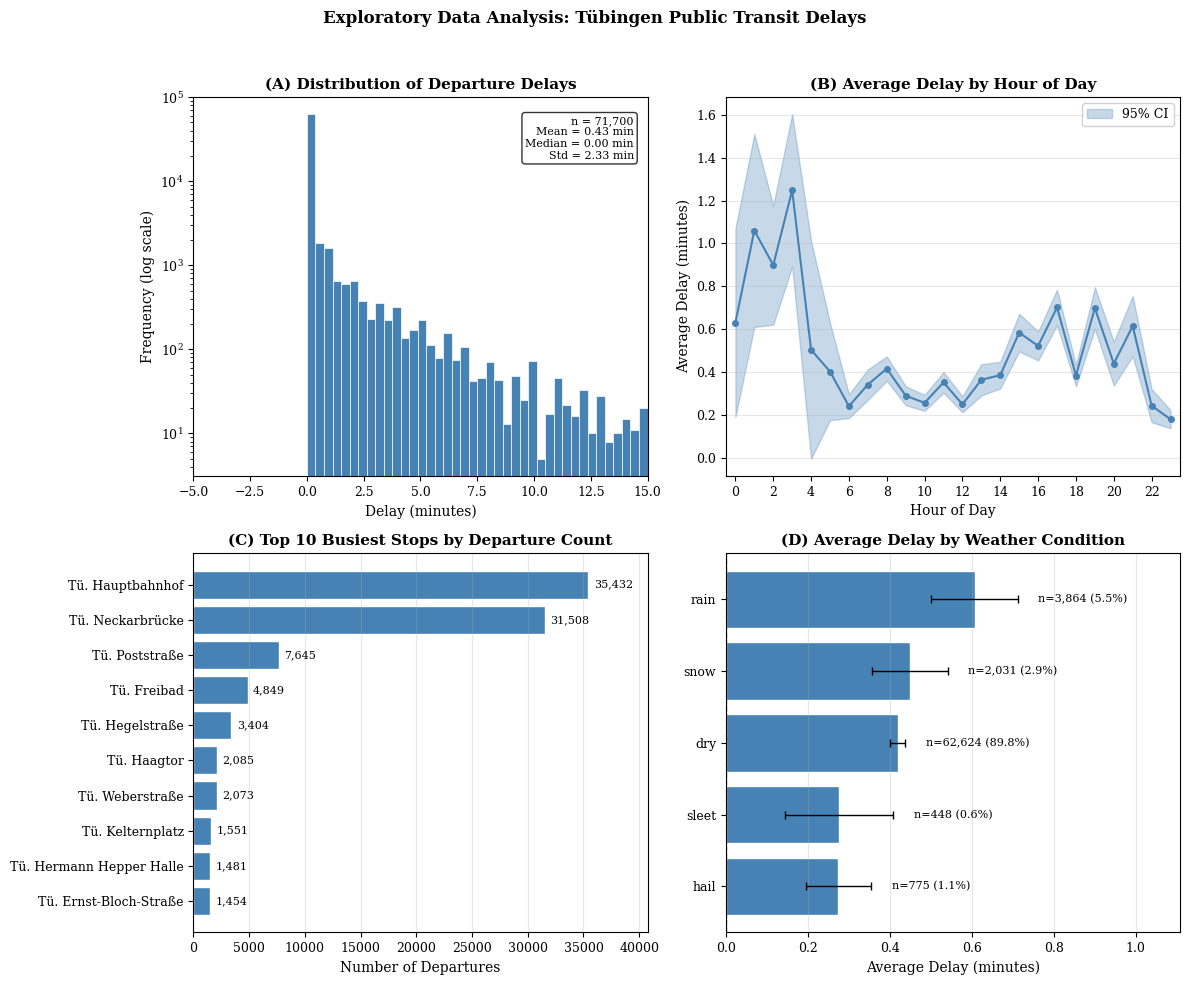

Figure saved as 'eda_4panel.png' and 'eda_4panel.pdf'


In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# =============================================================================
# Academic style settings for publication-quality figures
# =============================================================================
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 10,
    'axes.titlesize': 11,
    'axes.labelsize': 10,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'legend.fontsize': 9,
    'figure.titlesize': 12,
})

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Exploratory Data Analysis: Tübingen Public Transit Delays', fontweight='bold', y=0.98)

# =============================================================================
# Panel A: Delay Distribution
# - Zoomed to -5 to 15 min where most data lies (avoids long tail distortion)
# - LOG SCALE on y-axis to show distribution shape despite high peak at 0
# =============================================================================
ax = axes[0, 0]
delays = all_departure_data['delay_minutes'].dropna()

# Focus on -5 to 15 minutes where most data lies
delays_filtered = delays[(delays >= -5) & (delays <= 15)]

# Use log scale to handle the spike at 0
ax.hist(delays_filtered, bins=40, color='steelblue', edgecolor='white', linewidth=0.5, log=True)

ax.set_title('(A) Distribution of Departure Delays', fontweight='bold')
ax.set_xlabel('Delay (minutes)')
ax.set_ylabel('Frequency (log scale)')
ax.set_xlim(-5, 15)

# Summary statistics annotation
stats_text = f'n = {len(delays):,}\nMean = {delays.mean():.2f} min\nMedian = {delays.median():.2f} min\nStd = {delays.std():.2f} min'
ax.text(0.97, 0.95, stats_text, transform=ax.transAxes, fontsize=8, verticalalignment='top',
        horizontalalignment='right', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# =============================================================================
# Panel B: Average Delay by Hour of Day
# - Shows 95% confidence intervals to indicate statistical uncertainty
# - Helps identify peak delay hours (rush hour effects)
# - Hypothesis: Delays increase during rush hours (7-9, 16-18)
# =============================================================================
ax = axes[0, 1]
all_departure_data['hour'] = pd.to_datetime(all_departure_data['planned_time']).dt.hour

# Calculate mean and 95% CI per hour
hourly_stats = all_departure_data.groupby('hour')['delay_minutes'].agg(['mean', 'std', 'count'])
hourly_stats['se'] = hourly_stats['std'] / np.sqrt(hourly_stats['count'])
hourly_stats['ci95'] = 1.96 * hourly_stats['se']

ax.fill_between(hourly_stats.index,
                hourly_stats['mean'] - hourly_stats['ci95'],
                hourly_stats['mean'] + hourly_stats['ci95'],
                alpha=0.3, color='steelblue', label='95% CI')
ax.plot(hourly_stats.index, hourly_stats['mean'], 'o-', color='steelblue', linewidth=1.5, markersize=4)

ax.set_title('(B) Average Delay by Hour of Day', fontweight='bold')
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Average Delay (minutes)')
ax.set_xticks(range(0, 24, 2))
ax.set_xlim(-0.5, 23.5)
ax.legend(loc='upper right', framealpha=0.9)
ax.grid(axis='y', alpha=0.3)

# =============================================================================
# Panel C: Top 10 Busiest Stops
# - Shows departure frequency to understand data distribution
# - Hauptbahnhof dominates as expected (central hub)
# - Useful for understanding which stops drive aggregate statistics
# =============================================================================
ax = axes[1, 0]
stop_counts = all_departure_data['stop_name'].value_counts().head(10)

# Shorten stop names for readability (remove "Tübingen " prefix)
short_names = [name.replace('Tübingen ', 'Tü. ') for name in stop_counts.index]

bars = ax.barh(range(len(stop_counts)), stop_counts.values, color='steelblue', edgecolor='white')
ax.set_yticks(range(len(stop_counts)))
ax.set_yticklabels(short_names)
ax.invert_yaxis()

ax.set_title('(C) Top 10 Busiest Stops by Departure Count', fontweight='bold')
ax.set_xlabel('Number of Departures')
ax.set_ylabel('')

# Add value labels on bars
for i, (bar, val) in enumerate(zip(bars, stop_counts.values)):
    ax.text(val + 500, i, f'{val:,}', va='center', fontsize=8)

ax.set_xlim(0, stop_counts.max() * 1.15)
ax.grid(axis='x', alpha=0.3)

# =============================================================================
# Panel D: Average Delay by Weather Condition
# - Shows MEAN delay with 95% CI error bars
# - Labels placed OUTSIDE plot area to avoid overlap with bars
# - Sample sizes shown to assess reliability of estimates
# =============================================================================
ax = axes[1, 1]

# Group by weather condition and compute statistics
weather_stats = all_departure_data.groupby('condition')['delay_minutes'].agg(['mean', 'std', 'count'])
weather_stats = weather_stats[weather_stats['count'] >= 100]  # Filter conditions with <100 samples
weather_stats['se'] = weather_stats['std'] / np.sqrt(weather_stats['count'])
weather_stats['ci95'] = 1.96 * weather_stats['se']
weather_stats = weather_stats.sort_values('mean', ascending=True)

# Calculate percentage of total observations per condition
total_obs = weather_stats['count'].sum()
weather_stats['pct'] = 100 * weather_stats['count'] / total_obs

y_pos = range(len(weather_stats))
bars = ax.barh(y_pos, weather_stats['mean'], xerr=weather_stats['ci95'],
               color='steelblue', edgecolor='white', capsize=3, error_kw={'linewidth': 1})
ax.set_yticks(y_pos)
ax.set_yticklabels(weather_stats.index)

ax.axvline(0, color='darkred', linestyle='--', linewidth=1, alpha=0.7)
ax.set_title('(D) Average Delay by Weather Condition', fontweight='bold')
ax.set_xlabel('Average Delay (minutes)')
ax.set_ylabel('')
ax.grid(axis='x', alpha=0.3)

# Extend x-axis to make room for labels on the right
x_max = weather_stats['mean'].max() + weather_stats['ci95'].max()
ax.set_xlim(ax.get_xlim()[0], x_max * 1.5)

# Place labels to the RIGHT of the error bars, with clear black font
for i, (idx, row) in enumerate(weather_stats.iterrows()):
    label_x = row['mean'] + row['ci95'] + 0.05  # Position after error bar
    ax.text(label_x, i, f'n={int(row["count"]):,} ({row["pct"]:.1f}%)',
            va='center', ha='left', fontsize=8, fontweight='normal', color='black')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('eda_4panel.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.savefig('eda_4panel.pdf', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("Figure saved as 'eda_4panel.png' and 'eda_4panel.pdf'")

Grunddaten (EDA?)

In [42]:
# =========================
# Grunddaten: Mean, Median, CI95%
# Covers hypotheses via sensible groupings + produces a clean summary table.
# =========================

import numpy as np
import pandas as pd

df = all_departure_data.copy()

# ---- 1) Basic cleaning / preparation ----
# Ensure timestamps are datetime
for c in ["timestamp", "planned_time", "estimated_time", "weather_timestamp"]:
    if c in df.columns and not np.issubdtype(df[c].dtype, np.datetime64):
        df[c] = pd.to_datetime(df[c], errors="coerce")

# Delay: keep only rows where delay_minutes exists
df = df[df["delay_minutes"].notna()].copy()

# Add useful time fields
df["date"] = df["timestamp"].dt.date
df["weekday"] = df["timestamp"].dt.day_name()
df["weekday_num"] = df["timestamp"].dt.weekday  # 0=Mon ... 6=Sun
df["is_weekend"] = df["weekday_num"].isin([5, 6])
df["month"] = df["timestamp"].dt.to_period("M").astype(str)

# Hour already exists, but ensure it’s numeric
df["hour"] = pd.to_numeric(df["hour"], errors="coerce")

# Delay variants (for Hypothesis 1 and “often late”)
df["is_late"] = df["delay_minutes"] > 0
df["delay_pos"] = df["delay_minutes"].where(df["delay_minutes"] > 0, np.nan)  # delay among late buses only

# Weather “bad weather” flags (covers Hypothesis 2)
#  - condition-based (categorical)
#  - precipitation/wind/cloud as numeric groupings
df["is_rainy"] = df["precipitation_mm"].fillna(0) > 0
df["precip_bin"] = pd.cut(
    df["precipitation_mm"].fillna(0),
    bins=[-0.001, 0, 0.5, 2, 10, np.inf],
    labels=["0", "0-0.5", "0.5-2", "2-10", "10+"]
)
df["wind_bin"] = pd.qcut(df["wind_speed_ms"].dropna(), q=4, duplicates="drop")
df["temp_bin"] = pd.qcut(df["temperature"].dropna(), q=4, duplicates="drop")
df["cloud_bin"] = pd.qcut(df["cloud_cover"].dropna(), q=4, duplicates="drop")

# Time-of-day bins (Hypothesis 4 & 6)
df["daypart"] = pd.cut(
    df["hour"],
    bins=[-0.5, 5.5, 9.5, 15.5, 19.5, 23.5],
    labels=["Nacht (0-5)", "Morgen-Peak (6-9)", "Mittag (10-15)", "Abend-Peak (16-19)", "Spät (20-23)"]
)

# Traffic proxy for Hypothesis 6: bus stop "busyness" = number of departures at stop
# (You can later combine with hour/daypart for "verkehrsreiche Tageszeit")
stop_counts = df["stop_name"].value_counts()
df["stop_busyness"] = df["stop_name"].map(stop_counts)
df["stop_busyness_bin"] = pd.qcut(df["stop_busyness"], q=4, duplicates="drop")

# ---- 2) Stats helpers: mean, median, CI95% (bootstrap, robust) ----
def bootstrap_ci(x, stat_fn=np.mean, n_boot=2000, ci=0.95, seed=42):
    """Return (low, high) bootstrap CI for a 1D array-like x."""
    x = pd.Series(x).dropna().values
    if len(x) < 2:
        return (np.nan, np.nan)
    rng = np.random.default_rng(seed)
    stats = np.empty(n_boot, dtype=float)
    n = len(x)
    for i in range(n_boot):
        sample = rng.choice(x, size=n, replace=True)
        stats[i] = stat_fn(sample)
    alpha = 1 - ci
    return (np.quantile(stats, alpha / 2), np.quantile(stats, 1 - alpha / 2))

def summarize_series(x, label):
    """Compute n, mean, median, share late, and CI95% for mean (and median via bootstrap)."""
    x = pd.Series(x).dropna()
    n = len(x)
    if n == 0:
        return {
            "group": label,
            "n": 0,
            "mean": np.nan,
            "median": np.nan,
            "ci95_mean_low": np.nan,
            "ci95_mean_high": np.nan,
            "ci95_median_low": np.nan,
            "ci95_median_high": np.nan,
        }
    mean = x.mean()
    med = x.median()
    ci_mean = bootstrap_ci(x, stat_fn=np.mean)
    ci_med = bootstrap_ci(x, stat_fn=np.median)
    return {
        "group": label,
        "n": n,
        "mean": mean,
        "median": med,
        "ci95_mean_low": ci_mean[0],
        "ci95_mean_high": ci_mean[1],
        "ci95_median_low": ci_med[0],
        "ci95_median_high": ci_med[1],
    }

def group_summary(df_in, group_cols, value_col="delay_minutes", min_n=50, top_n=None):
    """
    Summarize delay stats by group_cols.
    - min_n filters small groups.
    - top_n keeps only top_n groups by frequency if group_cols is a single column.
    """
    d = df_in.copy()
    if isinstance(group_cols, str):
        group_cols = [group_cols]

    if top_n is not None and len(group_cols) == 1:
        counts = d[group_cols[0]].value_counts()
        keep = counts.head(top_n).index
        d = d[d[group_cols[0]].isin(keep)]

    out = []
    for keys, g in d.groupby(group_cols, dropna=False):
        if not isinstance(keys, tuple):
            keys = (keys,)
        label = " | ".join([f"{col}={val}" for col, val in zip(group_cols, keys)])
        x = g[value_col]
        if x.notna().sum() >= min_n:
            out.append(summarize_series(x, label))
    return pd.DataFrame(out)

# ---- 3) Build summaries for hypotheses ----
tables = []

# H1: "oft" zu spät -> overall + share late + delay among all and among late only
overall_all = summarize_series(df["delay_minutes"], "OVERALL: delay_minutes (all with estimated_time)")
overall_late = summarize_series(df["delay_pos"], "OVERALL: delay_minutes (late only; delay>0)")

# Add late share and n for late
late_share = df["is_late"].mean()
n_total = df["delay_minutes"].notna().sum()
n_late = df["is_late"].sum()

overall_df = pd.DataFrame([overall_all, overall_late])
overall_df["late_share"] = [late_share, late_share]
overall_df["n_total"] = [n_total, n_total]
overall_df["n_late"] = [n_late, n_late]
tables.append(overall_df)

# H2: Weather impact
if "condition" in df.columns:
    tables.append(group_summary(df, "condition", "delay_minutes", min_n=100))
tables.append(group_summary(df, "is_rainy", "delay_minutes", min_n=200))
tables.append(group_summary(df, "precip_bin", "delay_minutes", min_n=200))
if "wind_bin" in df.columns:
    tables.append(group_summary(df, "wind_bin", "delay_minutes", min_n=200))
if "temp_bin" in df.columns:
    tables.append(group_summary(df, "temp_bin", "delay_minutes", min_n=200))
if "cloud_bin" in df.columns:
    tables.append(group_summary(df, "cloud_bin", "delay_minutes", min_n=200))

# H3: Stop dependence (top 25 stops, because otherwise too many)
tables.append(group_summary(df, "stop_name", "delay_minutes", min_n=200, top_n=25))

# H4: Delay changes over the day
tables.append(group_summary(df, "hour", "delay_minutes", min_n=200))
tables.append(group_summary(df, "daypart", "delay_minutes", min_n=200))

# H5: Delays getting larger over time (choose daily or monthly trend)
tables.append(group_summary(df, "date", "delay_minutes", min_n=100))   # daily (may be many rows)
tables.append(group_summary(df, "month", "delay_minutes", min_n=200))  # monthly trend

# H6: Local accumulation where traffic is higher (proxy: busyness quartiles, optionally by daypart)
tables.append(group_summary(df, "stop_busyness_bin", "delay_minutes", min_n=200))
tables.append(group_summary(df, ["stop_busyness_bin", "daypart"], "delay_minutes", min_n=200))

# H8: Weekend vs weekday (and by weekday name)
tables.append(group_summary(df, "is_weekend", "delay_minutes", min_n=200))
tables.append(group_summary(df, "weekday", "delay_minutes", min_n=200))

# Extra: by line and destination (often helpful for interpretation)
tables.append(group_summary(df, "line_name", "delay_minutes", min_n=200, top_n=20))
tables.append(group_summary(df, "destination", "delay_minutes", min_n=200, top_n=20))

# ---- 4) Combine into one tidy summary table ----
summary_df = pd.concat(tables, ignore_index=True)

# Add helpful sorting columns
summary_df["abs_mean"] = summary_df["mean"].abs()
summary_df = summary_df.sort_values(["n", "abs_mean"], ascending=[False, False]).drop(columns=["abs_mean"])

# ---- 5) Display + optional export ----
display(summary_df.head(30))
print(f"Total summary rows: {len(summary_df)}")

summary_df.to_csv("grunddaten_mean_median_ci95_summary.csv", index=False)

/var/folders/n4/d1s6w7jn7jg1x7dnv_c53jd40000gn/T/ipykernel_30745/325716806.py:121: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for keys, g in d.groupby(group_cols, dropna=False):
/var/folders/n4/d1s6w7jn7jg1x7dnv_c53jd40000gn/T/ipykernel_30745/325716806.py:121: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for keys, g in d.groupby(group_cols, dropna=False):
/var/folders/n4/d1s6w7jn7jg1x7dnv_c53jd40000gn/T/ipykernel_30745/325716806.py:121: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or obs

,group,n,mean,median,ci95_mean_low,ci95_mean_high,ci95_median_low,ci95_median_high,late_share,n_total,n_late
0,OVERALL: delay_minutes (all with estimated_time),71700,0.426204,0.0,0.410232,0.443265,0.0,0.0,0.142622,71700.0,10226.0
8,is_rainy=False,69373,0.414275,0.0,0.397808,0.431806,0.0,0.0,NaN,NaN,NaN
10,precip_bin=0,69373,0.414275,0.0,0.397808,0.431806,0.0,0.0,NaN,NaN,NaN
2,condition=dry,62624,0.419010,0.0,0.400806,0.437817,0.0,0.0,NaN,NaN,NaN
114,is_weekend=False,54419,0.464726,0.0,0.444367,0.485027,0.0,0.0,NaN,NaN,NaN
23,"cloud_bin=(13.0, 100.0]",51858,0.439712,0.0,0.420081,0.460521,0.0,0.0,NaN,NaN,NaN
94,month=2025-12,43308,0.410518,0.0,0.390276,0.430568,0.0,0.0,NaN,NaN,NaN
95,month=2026-01,28392,0.450130,0.0,0.420751,0.480556,0.0,0.0,NaN,NaN,NaN
32,stop_name=Tübingen Neckarbrücke,27845,0.321153,0.0,0.299417,0.344422,0.0,0.0,NaN,NaN,NaN
98,"stop_busyness_bin=(25379.0, 27845.0]",27845,0.321153,0.0,0.299417,0.344422,0.0,0.0,NaN,NaN,NaN


Total summary rows: 163


In [43]:
# =========================
# 1) Baseline: OVERALL (all)
# =========================

baseline = summary_df[
    summary_df["group"].str.contains("OVERALL: delay_minutes (all", regex=False)
].iloc[0]

overall_mean = float(baseline["mean"])
overall_low  = float(baseline["ci95_mean_low"])
overall_high = float(baseline["ci95_mean_high"])

print(f"OVERALL mean={overall_mean:.3f}, CI95=[{overall_low:.3f}, {overall_high:.3f}]")

# =========================
# 2) Interpretation columns
# =========================

dfi = summary_df.copy()

# difference to overall
dfi["delta_mean"] = dfi["mean"] - overall_mean

# CI non-overlap logic
dfi["clearly_higher"] = dfi["ci95_mean_low"]  > overall_high
dfi["clearly_lower"]  = dfi["ci95_mean_high"] < overall_low

dfi["direction"] = np.where(
    dfi["clearly_higher"], "higher",
    np.where(dfi["clearly_lower"], "lower", "overlap")
)

# show only clearly higher OR clearly lower groups
dfi["show"] = dfi["clearly_higher"] | dfi["clearly_lower"]

# =========================
# 3) Helper: mini tables
# =========================

def mini_table(title, pattern, top=10, min_n=200):
    t = dfi[dfi["group"].str.contains(pattern, regex=True, na=False)].copy()
    t = t[~t["group"].str.contains("OVERALL:", regex=True, na=False)]
    t = t[t["n"] >= min_n]
    t = t[t["show"]]

    # show strongest higher AND strongest lower
    higher = t.sort_values("delta_mean", ascending=False).head(top)
    lower  = t.sort_values("delta_mean", ascending=True).head(top)

    t = pd.concat([higher, lower]).drop_duplicates()

    out = t[
        ["group","n","mean","ci95_mean_low","ci95_mean_high","delta_mean","direction"]
    ].copy()

    for c in ["mean","ci95_mean_low","ci95_mean_high","delta_mean"]:
        out[c] = out[c].astype(float).round(3)

    print("\n" + title)
    display(out.reset_index(drop=True))

    return out.reset_index(drop=True)

# =========================
# 4) Per-hypothesis tables
# =========================

# H2: Weather
h2 = mini_table(
    "H2 Weather (clearly different from overall)",
    pattern=r"(?:condition=|is_rainy=|precip_bin=|wind_bin=|temp_bin=|cloud_bin=)",
    top=8,
    min_n=200
)

# H3: Stops
h3 = mini_table(
    "H3 Stops (clearly different from overall)",
    pattern=r"(?:stop_name=)",
    top=8,
    min_n=200
)

# H4: Time of day
h4 = mini_table(
    "H4 Time of day (clearly different from overall)",
    pattern=r"(?:hour=|daypart=)",
    top=8,
    min_n=200
)

# H5: Trend over time (months)
h5 = mini_table(
    "H5 Trend over time (months, descriptive)",
    pattern=r"(?:month=)",
    top=8,
    min_n=200
)

# H6: Busy-area proxy
h6 = mini_table(
    "H6 Busy-area proxy (clearly different from overall)",
    pattern=r"(?:stop_busyness_bin=)",
    top=8,
    min_n=200
)

# H8: Weekend
h8 = mini_table(
    "H8 Weekend vs weekday (clearly different from overall)",
    pattern=r"(?:is_weekend=|weekday=)",
    top=8,
    min_n=200
)

# =========================
# 5) One slide-ready summary
# =========================

top = dfi[dfi["show"]].copy()
top = top[~top["group"].str.contains("OVERALL:", regex=True, na=False)]
top = top.sort_values("delta_mean", ascending=False).head(15)

top_out = top[
    ["group","n","mean","ci95_mean_low","ci95_mean_high","delta_mean","direction"]
].copy()

for c in ["mean","ci95_mean_low","ci95_mean_high","delta_mean"]:
    top_out[c] = top_out[c].astype(float).round(3)

print("\nTop findings (all groupings):")
display(top_out.reset_index(drop=True))

OVERALL mean=0.426, CI95=[0.410, 0.443]

H2 Weather (clearly different from overall)


,group,n,mean,ci95_mean_low,ci95_mean_high,delta_mean,direction
0,precip_bin=0.5-2,856,1.072,0.731,1.460,0.646,higher
1,is_rainy=True,2327,0.782,0.628,0.949,0.356,higher
2,precip_bin=0-0.5,1471,0.613,0.483,0.762,0.187,higher
3,condition=rain,3864,0.606,0.506,0.718,0.180,higher
4,"temp_bin=(3.4, 12.3]",17836,0.486,0.453,0.519,0.060,higher
5,"temp_bin=(-1.0, 1.1]",18333,0.370,0.342,0.400,-0.056,lower
6,condition=hail,775,0.275,0.196,0.359,-0.152,lower



H3 Stops (clearly different from overall)


,group,n,mean,ci95_mean_low,ci95_mean_high,delta_mean,direction
0,stop_name=Tübingen Freibad,3259,1.028,0.920,1.145,0.602,higher
1,stop_name=Tübingen Hauptbahnhof,25379,0.486,0.455,0.518,0.060,higher
2,stop_name=Tübingen Neckarbrücke,27845,0.321,0.299,0.344,-0.105,lower
3,stop_name=Tübingen Kelternplatz,1127,0.268,0.163,0.403,-0.158,lower
4,stop_name=Tübingen Weberstraße,1367,0.238,0.134,0.361,-0.188,lower
5,stop_name=Tübingen Hermann Hepper Halle,1147,0.163,0.096,0.268,-0.263,lower



H4 Time of day (clearly different from overall)


,group,n,mean,ci95_mean_low,ci95_mean_high,delta_mean,direction
0,"stop_busyness_bin=(5.999, 6085.0] | daypart=Na...",610,1.304,0.958,1.677,0.878,higher
1,hour=3,480,1.248,0.924,1.610,0.822,higher
2,hour=1,585,1.060,0.654,1.554,0.634,higher
3,hour=2,706,0.899,0.638,1.191,0.473,higher
4,daypart=Nacht (0-5),2976,0.819,0.676,0.972,0.393,higher
5,"stop_busyness_bin=(25379.0, 27845.0] | daypart...",1149,0.719,0.492,0.987,0.293,higher
6,hour=17,4521,0.702,0.621,0.788,0.275,higher
7,hour=19,3322,0.698,0.609,0.803,0.272,higher
8,hour=23,2337,0.180,0.141,0.226,-0.246,lower
9,"stop_busyness_bin=(25379.0, 27845.0] | daypart...",6547,0.229,0.197,0.261,-0.197,lower



H5 Trend over time (months, descriptive)


,group,n,mean,ci95_mean_low,ci95_mean_high,delta_mean,direction



H6 Busy-area proxy (clearly different from overall)


,group,n,mean,ci95_mean_low,ci95_mean_high,delta_mean,direction
0,"stop_busyness_bin=(5.999, 6085.0] | daypart=Na...",610,1.304,0.958,1.677,0.878,higher
1,"stop_busyness_bin=(25379.0, 27845.0] | daypart...",1149,0.719,0.492,0.987,0.293,higher
2,"stop_busyness_bin=(6085.0, 25379.0] | daypart=...",1217,0.670,0.468,0.877,0.244,higher
3,"stop_busyness_bin=(6085.0, 25379.0] | daypart=...",5976,0.670,0.600,0.748,0.244,higher
4,"stop_busyness_bin=(5.999, 6085.0] | daypart=Ab...",4274,0.622,0.548,0.698,0.196,higher
5,"stop_busyness_bin=(5.999, 6085.0]",18476,0.503,0.467,0.541,0.077,higher
6,"stop_busyness_bin=(6085.0, 25379.0]",25379,0.486,0.455,0.518,0.060,higher
7,"stop_busyness_bin=(25379.0, 27845.0]",27845,0.321,0.299,0.344,-0.105,lower
8,"stop_busyness_bin=(25379.0, 27845.0] | daypart...",6547,0.229,0.197,0.261,-0.197,lower
9,"stop_busyness_bin=(25379.0, 27845.0] | daypart...",3755,0.246,0.191,0.306,-0.180,lower



H8 Weekend vs weekday (clearly different from overall)


,group,n,mean,ci95_mean_low,ci95_mean_high,delta_mean,direction
0,weekday=Thursday,10236,0.541,0.481,0.602,0.115,higher
1,weekday=Monday,12207,0.501,0.460,0.544,0.075,higher
2,is_weekend=False,54419,0.465,0.444,0.485,0.039,higher
3,is_weekend=True,17281,0.305,0.276,0.336,-0.121,lower
4,weekday=Sunday,8589,0.242,0.205,0.284,-0.185,lower



Top findings (all groupings):


,group,n,mean,ci95_mean_low,ci95_mean_high,delta_mean,direction
0,line_name=18,2821,1.380,1.286,1.480,0.954,higher
1,"stop_busyness_bin=(5.999, 6085.0] | daypart=Na...",610,1.304,0.958,1.677,0.878,higher
2,hour=3,480,1.248,0.924,1.610,0.822,higher
3,precip_bin=0.5-2,856,1.072,0.731,1.460,0.646,higher
4,hour=1,585,1.060,0.654,1.554,0.634,higher
5,stop_name=Tübingen Freibad,3259,1.028,0.920,1.145,0.602,higher
6,hour=2,706,0.899,0.638,1.191,0.473,higher
7,daypart=Nacht (0-5),2976,0.819,0.676,0.972,0.393,higher
8,line_name=19,3085,0.800,0.709,0.895,0.374,higher
9,is_rainy=True,2327,0.782,0.628,0.949,0.356,higher


## Network Graph

In [44]:
all_trip_data = download_and_combine_data(trip_files)
print(f"Loaded {len(all_trip_data)} trip-call rows from {len(trip_files)} files.")

Processing 1268 files in parallel (max_workers=20)...
Processed 10/1268 files...
Processed 20/1268 files...
Processed 30/1268 files...
Processed 40/1268 files...
Processed 50/1268 files...
Processed 60/1268 files...
Processed 70/1268 files...
Processed 80/1268 files...
Processed 90/1268 files...
Processed 100/1268 files...
Processed 110/1268 files...
Processed 120/1268 files...
Processed 130/1268 files...
Processed 140/1268 files...
Processed 150/1268 files...
Processed 160/1268 files...
Processed 170/1268 files...
Processed 180/1268 files...
Processed 190/1268 files...
Processed 200/1268 files...
Processed 210/1268 files...
Processed 220/1268 files...
Processed 230/1268 files...
Processed 240/1268 files...
Processed 250/1268 files...
Processed 260/1268 files...
Processed 270/1268 files...
Processed 280/1268 files...
Processed 290/1268 files...
Processed 300/1268 files...
Processed 310/1268 files...
Processed 320/1268 files...
Processed 330/1268 files...
Processed 340/1268 files...
Pro

In [45]:
# =============================================================================
# TRIP DATA FILTERING (uses same controls as departure data)
# =============================================================================
# Apply the same date filter to trip data for consistency

if SPLIT_BY_SCHEDULE_CHANGE:
    if USE_DATA_BEFORE_CHANGE:
        date_filter = all_trip_data['timestamp'] < SCHEDULE_CHANGE_DATE
    else:
        date_filter = all_trip_data['timestamp'] >= SCHEDULE_CHANGE_DATE

    all_trip_data = all_trip_data[date_filter].copy()
    print(f"✓ Filtered trip data: {period_label}")
    print(f"  Rows: {len(all_trip_data):,}")
    print(f"  Date range: {all_trip_data['timestamp'].min()} to {all_trip_data['timestamp'].max()}")
else:
    print("✓ Using ALL trip data (no date filtering)")
    print(f"  Rows: {len(all_trip_data):,}")
    print(f"  Date range: {all_trip_data['timestamp'].min()} to {all_trip_data['timestamp'].max()}")

# --- Apply outlier filtering to trip data ---
if FILTER_DELAY_OUTLIERS and 'departure_delay_minutes' in all_trip_data.columns:
    outlier_mask = all_trip_data['departure_delay_minutes'] > DELAY_MAX_THRESHOLD
    n_outliers = outlier_mask.sum()

    if n_outliers > 0:
        all_trip_data = all_trip_data[~outlier_mask].copy()
        print(f"✓ Removed {n_outliers:,} trip outliers (delay > {DELAY_MAX_THRESHOLD} min)")
        print(f"  Rows after filtering: {len(all_trip_data):,}")

✓ Filtered trip data: AFTER schedule change (2025-12-14)
  Rows: 841,975
  Date range: 2025-12-14 00:00:21 to 2026-01-12 15:00:33
✓ Removed 69 trip outliers (delay > 90 min)
  Rows after filtering: 841,906


In [46]:
# Print data
display(all_trip_data.head(10))

,phase,stop_point_ref,stop_name,stop_sequence,platform,arrival_planned,arrival_estimated,departure_planned,departure_estimated,arrival_delay_minutes,departure_delay_minutes,journey_ref,operating_day_ref,line_name,destination,timestamp
771357,previous,de:08416:11000:11:C,Tübingen Hauptbahnhof,1,Bstg. C,NaN,NaN,2025-12-14 03:00:00,2025-12-14 03:05:12,NaN,5.2,tub:09091::H:j25:20,2025-12-14,N91,Tübingen Hauptbahnhof,2025-12-14 02:00:18
771358,onward,de:08416:10501:0:2,Tübingen Neckarbrücke,2,NaN,2025-12-14 03:01:12,2025-12-14 03:06:24,2025-12-14 03:01:12,2025-12-14 03:06:24,5.2,5.2,tub:09091::H:j25:20,2025-12-14,N91,Tübingen Hauptbahnhof,2025-12-14 02:00:18
771359,onward,de:08416:10520:0:2,Tübingen Wilhelmstraße,3,NaN,2025-12-14 03:01:54,2025-12-14 03:07:06,2025-12-14 03:01:54,2025-12-14 03:07:06,5.2,5.2,tub:09091::H:j25:20,2025-12-14,N91,Tübingen Hauptbahnhof,2025-12-14 02:00:18
771360,onward,de:08416:10503:0:2,Tübingen Uni / Neue Aula,4,NaN,2025-12-14 03:02:54,2025-12-14 03:08:06,2025-12-14 03:02:54,2025-12-14 03:08:06,5.2,5.2,tub:09091::H:j25:20,2025-12-14,N91,Tübingen Hauptbahnhof,2025-12-14 02:00:18
771361,onward,de:08416:10504:0:1,Tübingen Lothar-Meyer-Bau,5,NaN,2025-12-14 03:04:06,2025-12-14 03:09:18,2025-12-14 03:04:06,2025-12-14 03:09:18,5.2,5.2,tub:09091::H:j25:20,2025-12-14,N91,Tübingen Hauptbahnhof,2025-12-14 02:00:18
771362,onward,de:08416:10505:0:1,Tübingen Pauline-Krone-Heim,6,NaN,2025-12-14 03:05:24,2025-12-14 03:10:36,2025-12-14 03:05:24,2025-12-14 03:10:36,5.2,5.2,tub:09091::H:j25:20,2025-12-14,N91,Tübingen Hauptbahnhof,2025-12-14 02:00:18
771363,onward,de:08416:10300:0:1,Tübingen Landhausstraße,7,NaN,2025-12-14 03:06:18,2025-12-14 03:11:30,2025-12-14 03:06:18,2025-12-14 03:11:30,5.2,5.2,tub:09091::H:j25:20,2025-12-14,N91,Tübingen Hauptbahnhof,2025-12-14 02:00:18
771364,onward,de:08416:10313:0:1,Tübingen Benzstraße,8,NaN,2025-12-14 03:06:36,2025-12-14 03:11:48,2025-12-14 03:06:36,2025-12-14 03:11:48,5.2,5.2,tub:09091::H:j25:20,2025-12-14,N91,Tübingen Hauptbahnhof,2025-12-14 02:00:18
771365,onward,de:08416:10301:0:1,Tübingen Dorfstraße,9,NaN,2025-12-14 03:07:24,2025-12-14 03:12:36,2025-12-14 03:07:24,2025-12-14 03:12:36,5.2,5.2,tub:09091::H:j25:20,2025-12-14,N91,Tübingen Hauptbahnhof,2025-12-14 02:00:18
771366,onward,de:08416:10319:0:1,Tübingen Steige,10,NaN,2025-12-14 03:09:30,2025-12-14 03:14:42,2025-12-14 03:09:30,2025-12-14 03:14:42,5.2,5.2,tub:09091::H:j25:20,2025-12-14,N91,Tübingen Hauptbahnhof,2025-12-14 02:00:18


Join coordinates into trip data and fetch missing from TRIAS api

In [47]:
from trias import TriasClient

# =============================================================================
# STEP 1: Discover stops via multi-center TRIAS queries
# =============================================================================
# The TRIAS API returns ~14 stops per request. By querying from multiple centers
# (existing stops with known coordinates), we can discover more stops.

trias_client = TriasClient(requestor_ref="SeBaSTiaN_BoeHLeR")

# Get initial centers from departure data
initial_centers = (
    all_departure_data
    .dropna(subset=['latitude', 'longitude'])
    .groupby('stop_id', as_index=False)
    .agg({'latitude': 'first', 'longitude': 'first', 'stop_name': 'first'})
    .head(20)  # Start with 20 centers
)

print(f"Discovering stops using {len(initial_centers)} initial centers...")

discovered_stops = {}  # stop_id -> {stop_id, stop_name, latitude, longitude}
processed_centers = set()

def discover_from_center(lat, lon, radius_km=3):
    """Fetch stops from TRIAS API using given center coordinates."""
    try:
        stops = trias_client.fetch_stops(center=(lat, lon), radius_km=radius_km, max_results=200)
        return stops
    except Exception:
        return pd.DataFrame()

# Initial discovery from departure data centers
for _, row in initial_centers.iterrows():
    stops = discover_from_center(row['latitude'], row['longitude'])
    for _, s in stops.iterrows():
        if s['stop_id'] not in discovered_stops:
            discovered_stops[s['stop_id']] = {
                'stop_id': s['stop_id'],
                'stop_name': s.get('stop_name'),
                'latitude': s.get('latitude'),
                'longitude': s.get('longitude'),
            }
    processed_centers.add(row['stop_id'])

print(f"After initial discovery: {len(discovered_stops)} stops")

# Iterative expansion: use newly discovered stops as centers
for iteration in range(3):
    new_centers = [
        s for sid, s in discovered_stops.items()
        if sid not in processed_centers
        and pd.notna(s.get('latitude'))
        and pd.notna(s.get('longitude'))
    ]

    if not new_centers:
        break

    new_discoveries = 0
    for stop in new_centers[:15]:  # Limit API calls per iteration
        processed_centers.add(stop['stop_id'])
        stops = discover_from_center(stop['latitude'], stop['longitude'])
        for _, s in stops.iterrows():
            if s['stop_id'] not in discovered_stops:
                discovered_stops[s['stop_id']] = {
                    'stop_id': s['stop_id'],
                    'stop_name': s.get('stop_name'),
                    'latitude': s.get('latitude'),
                    'longitude': s.get('longitude'),
                }
                new_discoveries += 1

    print(f"Iteration {iteration + 1}: +{new_discoveries} stops, total: {len(discovered_stops)}")
    if new_discoveries == 0:
        break

# Create DataFrame of discovered stops
trias_stops_df = pd.DataFrame(discovered_stops.values())
print(f"\nTotal discovered stops with coordinates: {len(trias_stops_df)}")

# =============================================================================
# STEP 2: Join coordinates from multiple sources onto trip data
# =============================================================================

# Source 1: Departure data coordinates (by stop_point_ref)
dep_coords_ref = (
    all_departure_data
    .dropna(subset=['latitude', 'longitude'])
    .groupby('stop_point_ref', as_index=False)[['latitude', 'longitude']]
    .mean()
)

# Source 2: Departure data coordinates (by stop_name as fallback)
dep_coords_name = (
    all_departure_data
    .dropna(subset=['latitude', 'longitude'])
    .groupby('stop_name', as_index=False)[['latitude', 'longitude']]
    .mean()
)

# Source 3: TRIAS discovered stops (by stop_id - base ID without platform suffix)
trias_coords = (
    trias_stops_df
    .dropna(subset=['latitude', 'longitude'])
    .rename(columns={'latitude': 'lat_trias', 'longitude': 'lon_trias'})
)

# Drop any existing coordinate columns
for col in ['latitude', 'longitude']:
    if col in all_trip_data.columns:
        all_trip_data = all_trip_data.drop(columns=[col])

# Extract base stop_id from stop_point_ref for TRIAS matching
# stop_point_ref like "de:08416:10044:0:1" -> stop_id "de:08416:10044"
all_trip_data['stop_id_base'] = all_trip_data['stop_point_ref'].str.extract(r'^(de:\d+:\d+)')[0]

# Join 1: From departure data by stop_point_ref
all_trip_data = all_trip_data.merge(dep_coords_ref, on='stop_point_ref', how='left')

# Join 2: From TRIAS by base stop_id
all_trip_data = all_trip_data.merge(
    trias_coords[['stop_id', 'lat_trias', 'lon_trias']],
    left_on='stop_id_base',
    right_on='stop_id',
    how='left'
)

# Fill missing coords from TRIAS
all_trip_data['latitude'] = all_trip_data['latitude'].fillna(all_trip_data['lat_trias'])
all_trip_data['longitude'] = all_trip_data['longitude'].fillna(all_trip_data['lon_trias'])

# Join 3: Fallback by stop_name
missing_mask = all_trip_data['latitude'].isna() | all_trip_data['longitude'].isna()
if missing_mask.any():
    fallback = (
        all_trip_data[missing_mask]
        .merge(dep_coords_name, on='stop_name', how='left', suffixes=('', '_fb'))
    )
    all_trip_data.loc[missing_mask, 'latitude'] = fallback['latitude_fb'].values
    all_trip_data.loc[missing_mask, 'longitude'] = fallback['longitude_fb'].values

# Clean up temporary columns
all_trip_data = all_trip_data.drop(columns=['stop_id_base', 'stop_id', 'lat_trias', 'lon_trias'], errors='ignore')

# Report coverage
stops_total = all_trip_data['stop_point_ref'].nunique()
stops_with_coords = all_trip_data[
    all_trip_data['latitude'].notna() & all_trip_data['longitude'].notna()
]['stop_point_ref'].nunique()

print(f"\nCoordinate coverage: {stops_with_coords}/{stops_total} unique stops ({100*stops_with_coords/stops_total:.1f}%)")

Discovering stops using 16 initial centers...
After initial discovery: 111 stops
Iteration 1: +26 stops, total: 137
Iteration 2: +18 stops, total: 155
Iteration 3: +11 stops, total: 166

Total discovered stops with coordinates: 166

Coordinate coverage: 250/1100 unique stops (22.7%)


In [48]:
import networkx as nx
from ipysigma import Sigma

print(f"Raw trip data: {len(all_trip_data):,} rows")

# =============================================================================
# STEP 1: Deduplicate trip data
# =============================================================================
# Trip data is sampled hourly, so the same trip appears multiple times.
# Each sample contains all stops with phase='previous' (visited) or 'onward' (upcoming).
# We keep only one row per (trip, stop) combination using the latest sample.

trip_deduped = all_trip_data.copy()

# Create unique trip identifier
trip_deduped['trip_id'] = (
    trip_deduped['journey_ref'] + '_' + trip_deduped['operating_day_ref'].astype(str)
)

# Sort by timestamp descending to keep latest observation
trip_deduped = trip_deduped.sort_values('timestamp', ascending=False)

# Drop duplicates, keeping first (latest) per (trip, stop)
trip_deduped = trip_deduped.drop_duplicates(
    subset=['trip_id', 'stop_point_ref', 'stop_sequence'],
    keep='first'
)

print(f"After deduplication: {len(trip_deduped):,} rows "
      f"({100*(1-len(trip_deduped)/len(all_trip_data)):.1f}% reduction)")

# =============================================================================
# STEP 2: Filter to stops with coordinates
# =============================================================================
trip_filtered = trip_deduped[
    trip_deduped['latitude'].notna() & trip_deduped['longitude'].notna()
].copy()

print(f"After filtering to stops with coordinates: {len(trip_filtered):,} rows")

# =============================================================================
# STEP 3: Filter to ONLY Tübingen stops (exclude Rottenburg, Reutlingen, etc.)
# =============================================================================
# Tübingen area bounding box (approximate):
# Latitude: 48.50 - 48.55 (north-south)
# Longitude: 9.03 - 9.10 (east-west)

TUEBINGEN_LAT_MIN = 48.50
TUEBINGEN_LAT_MAX = 48.55
TUEBINGEN_LON_MIN = 9.03
TUEBINGEN_LON_MAX = 9.10

# Also filter by stop_name prefix as backup
tuebingen_mask = (
    (trip_filtered['latitude'] >= TUEBINGEN_LAT_MIN) &
    (trip_filtered['latitude'] <= TUEBINGEN_LAT_MAX) &
    (trip_filtered['longitude'] >= TUEBINGEN_LON_MIN) &
    (trip_filtered['longitude'] <= TUEBINGEN_LON_MAX)
) | trip_filtered['stop_name'].str.startswith('Tübingen', na=False)

trip_filtered = trip_filtered[tuebingen_mask].copy()

print(f"After filtering to Tübingen area: {len(trip_filtered):,} rows")
print(f"Unique stops (by stop_point_ref): {trip_filtered['stop_point_ref'].nunique()}")

# Debug: show coordinate ranges
print(f"\nCoordinate ranges in filtered data:")
print(f"  Latitude:  {trip_filtered['latitude'].min():.4f} - {trip_filtered['latitude'].max():.4f}")
print(f"  Longitude: {trip_filtered['longitude'].min():.4f} - {trip_filtered['longitude'].max():.4f}")

# =============================================================================
# STEP 4: Create unified stop key (by stop_name + rounded coordinates)
# =============================================================================
# This unifies stops like "Tübingen Parkhaus König" that have multiple platform
# suffixes (e.g., :0:2, :0:3, :0:4) but represent the same physical location.

# Round coordinates to 4 decimal places (~11m precision) to group nearby platforms
trip_filtered['lat_rounded'] = trip_filtered['latitude'].round(4)
trip_filtered['lon_rounded'] = trip_filtered['longitude'].round(4)

# Create unified stop key: stop_name + rounded coordinates
trip_filtered['unified_stop'] = (
    trip_filtered['stop_name'] + '_' +
    trip_filtered['lat_rounded'].astype(str) + '_' +
    trip_filtered['lon_rounded'].astype(str)
)

print(f"Unique stops after unification (by name+coords): {trip_filtered['unified_stop'].nunique()}")

# =============================================================================
# STEP 5: Prepare data for graph construction
# =============================================================================
trip_filtered['stop_sequence'] = pd.to_numeric(
    trip_filtered['stop_sequence'], errors='coerce'
)
trip_filtered = trip_filtered.dropna(
    subset=['journey_ref', 'stop_point_ref', 'stop_sequence']
)

for col in ['departure_delay_minutes', 'arrival_delay_minutes']:
    if col in trip_filtered.columns:
        trip_filtered[col] = pd.to_numeric(trip_filtered[col], errors='coerce')

# Prefer departure delay, fall back to arrival delay
delay_col = 'departure_delay_minutes' if 'departure_delay_minutes' in trip_filtered.columns else 'arrival_delay_minutes'

# =============================================================================
# STEP 6: Build edges using UNIFIED stops (consecutive stops within same trip)
# =============================================================================
trip_sorted = trip_filtered.sort_values(['trip_id', 'stop_sequence'])

# Use unified_stop for edges instead of stop_point_ref
trip_sorted['next_stop'] = trip_sorted.groupby('trip_id')['unified_stop'].shift(-1)
trip_sorted['next_delay'] = trip_sorted.groupby('trip_id')[delay_col].shift(-1)

# Only keep edges where next stop exists
edges_raw = trip_sorted.dropna(subset=['next_stop'])

# Aggregate edges: count unique trips per edge, mean delay
edge_agg = (
    edges_raw
    .groupby(['unified_stop', 'next_stop'], as_index=False)
    .agg(
        mean_delay=(delay_col, 'mean'),
        num_trips=('trip_id', 'nunique'),
    )
    .rename(columns={'unified_stop': 'from_stop', 'next_stop': 'to_stop'})
)

print(f"Network edges (unified): {len(edge_agg):,}")

# =============================================================================
# STEP 7: Build UNIFIED node metadata
# =============================================================================
# Aggregate by unified_stop to combine platforms into single nodes
stop_meta = (
    trip_filtered
    .groupby('unified_stop', as_index=False)
    .agg(
        stop_name=('stop_name', 'first'),
        latitude=('latitude', 'mean'),  # Average coordinates across platforms
        longitude=('longitude', 'mean'),
        num_platforms=('stop_point_ref', 'nunique'),  # Count how many platforms were unified
    )
)

# Filter to only stops with valid coordinates
stop_meta = stop_meta[stop_meta['latitude'].notna() & stop_meta['longitude'].notna()]
valid_stops = set(stop_meta['unified_stop'])

# Filter edges to only include stops with valid coordinates on BOTH ends
edge_agg = edge_agg[
    edge_agg['from_stop'].isin(valid_stops) & edge_agg['to_stop'].isin(valid_stops)
]

print(f"Edges after filtering to valid coordinates: {len(edge_agg):,}")

# Average delay per node (based on outgoing edges)
node_delay = (
    edge_agg
    .groupby('from_stop')['mean_delay']
    .mean()
    .rename('avg_delay')
)

stop_meta = stop_meta.merge(
    node_delay, left_on='unified_stop', right_index=True, how='left'
)

# =============================================================================
# STEP 8: Build NetworkX graph with UNIFIED nodes
# =============================================================================
G = nx.DiGraph()

for _, row in stop_meta.iterrows():
    label = row["stop_name"]
    # Add platform count if multiple platforms were unified
    if row['num_platforms'] > 1:
        label += f" ({row['num_platforms']} platforms)"
    G.add_node(
        row['unified_stop'],
        label=label,
        latitude=row['latitude'],
        longitude=row['longitude'],
        avg_delay=row['avg_delay'],
    )

for _, row in edge_agg.iterrows():
    G.add_edge(
        row['from_stop'],
        row['to_stop'],
        mean_delay=row['mean_delay'],
        num_trips=row['num_trips'],
    )

print(f"\nGraph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")
print(f"(Unified from {trip_filtered['stop_point_ref'].nunique()} original stop_point_refs)")

# Show sample of stops to verify
print(f"\nSample stops in graph:")
for i, (_, row) in enumerate(stop_meta.head(5).iterrows()):
    print(f"  {row['stop_name']}: ({row['latitude']:.4f}, {row['longitude']:.4f})")

# Clean up temporary column
trip_filtered = trip_filtered.drop(columns=['trip_id', 'lat_rounded', 'lon_rounded', 'unified_stop'], errors='ignore')

Raw trip data: 841,906 rows
After deduplication: 789,708 rows (6.2% reduction)
After filtering to stops with coordinates: 339,288 rows
After filtering to Tübingen area: 329,527 rows
Unique stops (by stop_point_ref): 201

Coordinate ranges in filtered data:
  Latitude:  48.5069 - 48.5363
  Longitude: 9.0288 - 9.0720
Unique stops after unification (by name+coords): 96
Network edges (unified): 235
Edges after filtering to valid coordinates: 235

Graph has 96 nodes and 235 edges.
(Unified from 201 original stop_point_refs)

Sample stops in graph:
  Tübingen Aischbachstraße: (48.5239, 9.0427)
  Tübingen Albrechtstraße: (48.5115, 9.0517)
  Tübingen Alter Güterbahnhof: (48.5154, 9.0684)
  Tübingen Biererstraße: (48.5174, 9.0618)
  Tübingen Biesingerstraße: (48.5168, 9.0437)


The following cell will create and save a html file that can then be opened to view and interact with the network graph

In [49]:
Sigma.write_html(
    graph=G,
    path="bus_network_sigma.html",
    fullscreen=True,
    node_label="label",
    default_node_color="#DDDDDD",
    default_node_size=3,
    edge_color="mean_delay",
    edge_color_gradient="Reds",
    edge_color_scale="lin",
    edge_size="mean_delay",
    edge_size_range=(0.5, 4),
)

# Academic Hypothesis Plots

Publication-quality figures for the Data Literacy course paper. Each plot addresses a specific hypothesis from the meeting notes, following course guidelines:
- **Estimators + Confidence Intervals** over p-values
- **DKW bands** for ECDFs
- **Bootstrap CIs** for medians and percentiles
- Clear annotations with interpretable metrics

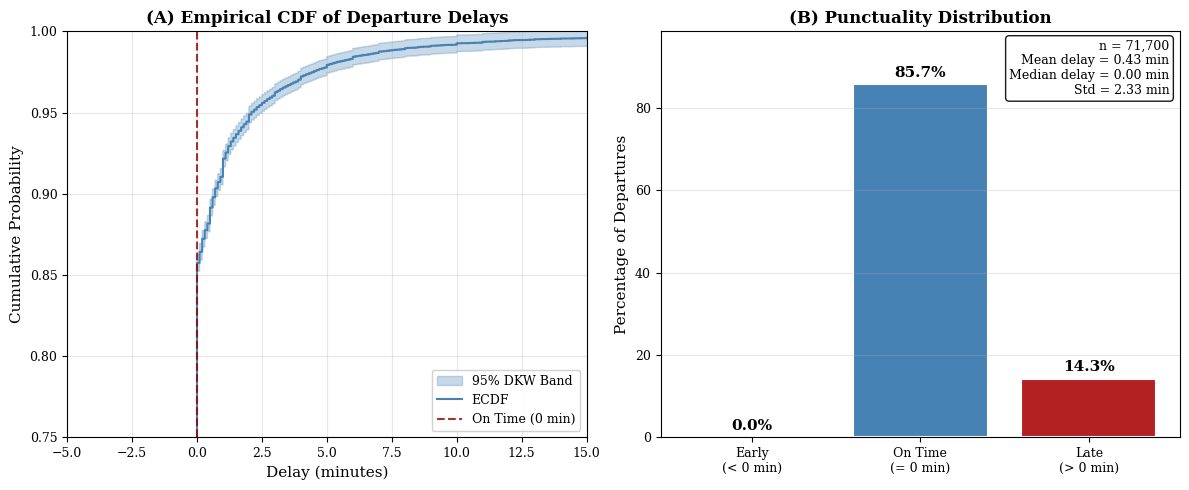


HYPOTHESIS 1 SUMMARY: Are Tübingen buses often late?
  Total observations: 71,700
  Late rate (delay > 0): 14.3%
  On-time rate (delay = 0): 85.7%
  Early rate (delay < 0): 0.0%
  Mean delay: 0.43 min
  Median delay: 0.00 min


In [50]:
# =============================================================================
# HYPOTHESIS 1: "Tübinger Busse sind oft zu spät"
# Figure: ECDF with DKW confidence bands + key metrics annotated
# =============================================================================
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Academic style
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 10,
    'axes.titlesize': 12,
    'axes.labelsize': 11,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
})

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Get delay data
delays = all_departure_data['delay_minutes'].dropna().values

# --- Panel A: ECDF with DKW confidence bands ---
ax = axes[0]

# Sort delays for ECDF
x_sorted = np.sort(delays)
n = len(x_sorted)
ecdf_y = np.arange(1, n + 1) / n

# DKW confidence bands (95%)
alpha = 0.05
epsilon = np.sqrt(np.log(2 / alpha) / (2 * n))
lower = np.clip(ecdf_y - epsilon, 0, 1)
upper = np.clip(ecdf_y + epsilon, 0, 1)

# Plot ECDF with bands
ax.fill_between(x_sorted, lower, upper, alpha=0.3, color='steelblue', label='95% DKW Band')
ax.step(x_sorted, ecdf_y, where='post', color='steelblue', linewidth=1.5, label='ECDF')

# Mark key thresholds
ax.axvline(0, color='darkred', linestyle='--', linewidth=1.5, alpha=0.8, label='On Time (0 min)')
ax.axhline(0.5, color='gray', linestyle=':', linewidth=1, alpha=0.6)

# Annotate late rate
late_rate = np.mean(delays > 0)
on_time_rate = np.mean(delays == 0)
early_rate = np.mean(delays < 0)

ax.set_xlabel('Delay (minutes)')
ax.set_ylabel('Cumulative Probability')
ax.set_title('(A) Empirical CDF of Departure Delays', fontweight='bold')
ax.set_xlim(-5, 15)
ax.set_ylim(0.75, 1.0)
ax.legend(loc='lower right', framealpha=0.9)
ax.grid(alpha=0.3)

# --- Panel B: Summary statistics ---
ax = axes[1]

# Create summary bar chart
categories = ['Early\n(< 0 min)', 'On Time\n(= 0 min)', 'Late\n(> 0 min)']
values = [early_rate * 100, on_time_rate * 100, late_rate * 100]
colors = ['forestgreen', 'steelblue', 'firebrick']

bars = ax.bar(categories, values, color=colors, edgecolor='white', linewidth=1.5)

# Add value labels on bars
for bar, val in zip(bars, values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
            f'{val:.1f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.set_ylabel('Percentage of Departures')
ax.set_title('(B) Punctuality Distribution', fontweight='bold')
ax.set_ylim(0, max(values) * 1.15)
ax.grid(axis='y', alpha=0.3)

# Add summary stats text box
stats_text = (f'n = {n:,}\n'
              f'Mean delay = {np.mean(delays):.2f} min\n'
              f'Median delay = {np.median(delays):.2f} min\n'
              f'Std = {np.std(delays):.2f} min')
ax.text(0.98, 0.98, stats_text, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))

plt.tight_layout()
plt.savefig('fig1_hypothesis1_delay_ecdf.pdf', dpi=300, bbox_inches='tight')
plt.savefig('fig1_hypothesis1_delay_ecdf.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "="*70)
print("HYPOTHESIS 1 SUMMARY: Are Tübingen buses often late?")
print("="*70)
print(f"  Total observations: {n:,}")
print(f"  Late rate (delay > 0): {100*late_rate:.1f}%")
print(f"  On-time rate (delay = 0): {100*on_time_rate:.1f}%")
print(f"  Early rate (delay < 0): {100*early_rate:.1f}%")
print(f"  Mean delay: {np.mean(delays):.2f} min")
print(f"  Median delay: {np.median(delays):.2f} min")
print("="*70)

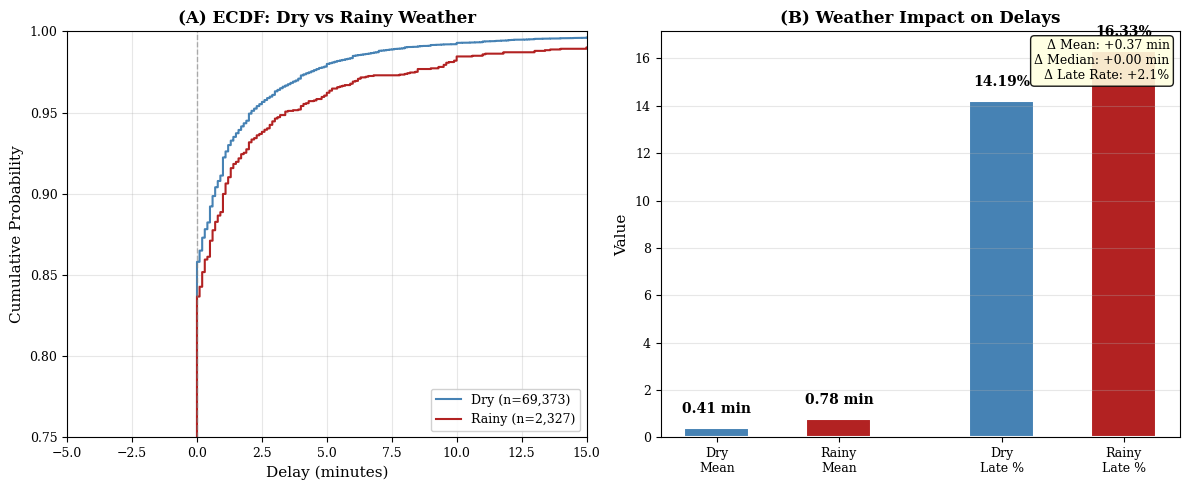


HYPOTHESIS 2 SUMMARY: Are delays larger in bad weather?
  Dry weather:  n=69,373, mean=0.41 min, median=0.00 min, late=14.2%
  Rainy weather: n=2,327, mean=0.78 min, median=0.00 min, late=16.3%
  Difference: Δmean=+0.37 min, Δmedian=+0.00 min, Δlate=+2.1%


In [51]:
# =============================================================================
# HYPOTHESIS 2: "Verspätung ist größer bei schlechtem Wetter"
# Figure: ECDF comparison dry vs rainy with DKW bands + effect size
# =============================================================================
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Define weather groups: dry vs rainy (precipitation > 0)
df = all_departure_data.copy()
df['is_rainy'] = df['precipitation_mm'] > 0

delays_dry = df.loc[~df['is_rainy'], 'delay_minutes'].dropna().values
delays_rainy = df.loc[df['is_rainy'], 'delay_minutes'].dropna().values

# --- Panel A: ECDF comparison ---
ax = axes[0]

for delays, label, color in [(delays_dry, 'Dry', 'steelblue'),
                              (delays_rainy, 'Rainy', 'firebrick')]:
    x_sorted = np.sort(delays)
    n = len(x_sorted)
    ecdf_y = np.arange(1, n + 1) / n
    ax.step(x_sorted, ecdf_y, where='post', color=color, linewidth=1.5, label=f'{label} (n={n:,})')

ax.axvline(0, color='gray', linestyle='--', linewidth=1, alpha=0.6)
ax.set_xlabel('Delay (minutes)')
ax.set_ylabel('Cumulative Probability')
ax.set_title('(A) ECDF: Dry vs Rainy Weather', fontweight='bold')
ax.set_xlim(-5, 15)
ax.set_ylim(0.75, 1.0)
ax.legend(loc='lower right', framealpha=0.9)
ax.grid(alpha=0.3)

# --- Panel B: Summary comparison (using MEAN since median is often 0) ---
ax = axes[1]

# Calculate statistics
stats = {
    'Dry': {
        'mean': np.mean(delays_dry),
        'median': np.median(delays_dry),
        'late_rate': np.mean(delays_dry > 0),
        'n': len(delays_dry)
    },
    'Rainy': {
        'mean': np.mean(delays_rainy),
        'median': np.median(delays_rainy),
        'late_rate': np.mean(delays_rainy > 0),
        'n': len(delays_rainy)
    }
}

# Bar chart comparing mean delay and late rate
x_pos = np.array([0, 1.5, 3.5, 5])
labels = ['Dry\nMean', 'Rainy\nMean', 'Dry\nLate %', 'Rainy\nLate %']
values = [stats['Dry']['mean'], stats['Rainy']['mean'],
          stats['Dry']['late_rate'] * 100, stats['Rainy']['late_rate'] * 100]
colors = ['steelblue', 'firebrick', 'steelblue', 'firebrick']

bars = ax.bar(x_pos, values, color=colors, edgecolor='white', linewidth=1.5, width=0.8)

# Add value labels
for bar, val, pos in zip(bars, values, x_pos):
    unit = ' min' if pos < 2 else '%'
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
            f'{val:.2f}{unit}', ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.set_ylabel('Value')
ax.set_title('(B) Weather Impact on Delays', fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Add effect size annotation
diff_mean = stats['Rainy']['mean'] - stats['Dry']['mean']
diff_median = stats['Rainy']['median'] - stats['Dry']['median']
diff_late = (stats['Rainy']['late_rate'] - stats['Dry']['late_rate']) * 100

effect_text = (f"Δ Mean: {diff_mean:+.2f} min\n"
               f"Δ Median: {diff_median:+.2f} min\n"
               f"Δ Late Rate: {diff_late:+.1f}%")
ax.text(0.98, 0.98, effect_text, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.9))

plt.tight_layout()
plt.savefig('fig2_hypothesis2_weather.pdf', dpi=300, bbox_inches='tight')
plt.savefig('fig2_hypothesis2_weather.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "="*70)
print("HYPOTHESIS 2 SUMMARY: Are delays larger in bad weather?")
print("="*70)
print(f"  Dry weather:  n={stats['Dry']['n']:,}, mean={stats['Dry']['mean']:.2f} min, "
      f"median={stats['Dry']['median']:.2f} min, late={100*stats['Dry']['late_rate']:.1f}%")
print(f"  Rainy weather: n={stats['Rainy']['n']:,}, mean={stats['Rainy']['mean']:.2f} min, "
      f"median={stats['Rainy']['median']:.2f} min, late={100*stats['Rainy']['late_rate']:.1f}%")
print(f"  Difference: Δmean={diff_mean:+.2f} min, Δmedian={diff_median:+.2f} min, Δlate={diff_late:+.1f}%")
print("="*70)

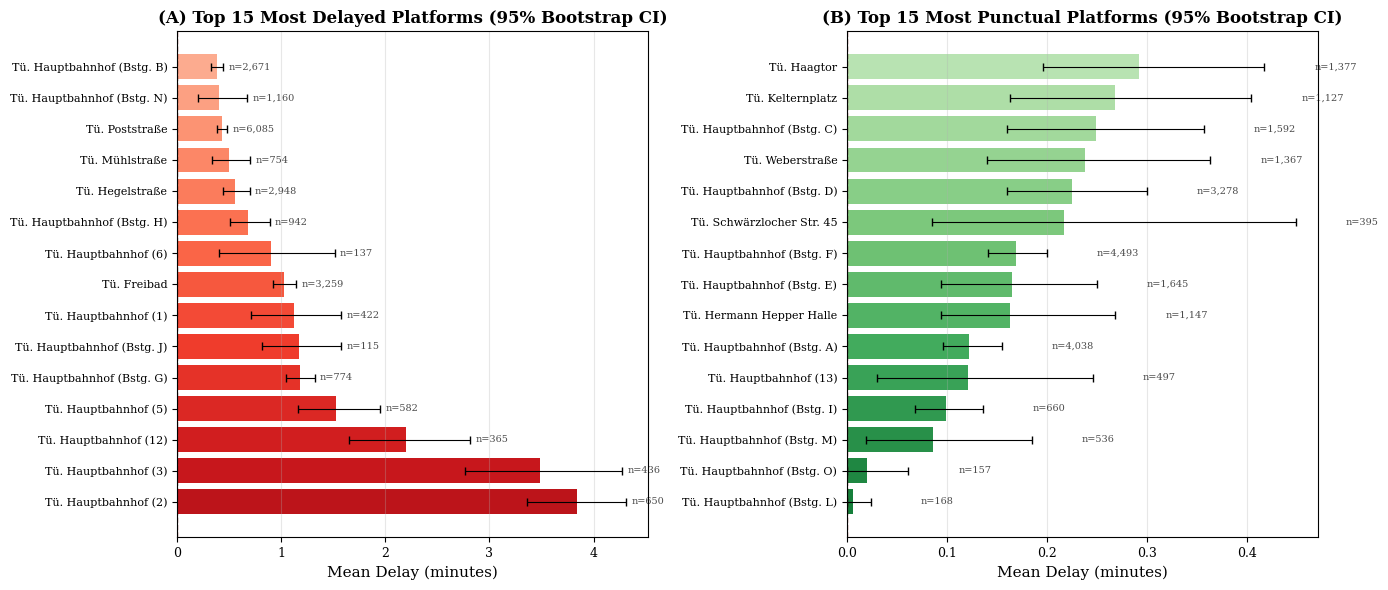


HYPOTHESIS 3 SUMMARY: Do delays depend on stops?
  Granularity: Platform-level
  Platforms analyzed (n≥100): 31
  Range of mean delays: 0.01 to 3.84 min

  Top 5 most delayed platforms:
    - Tü. Hauptbahnhof (2): mean=3.84 min, late=58.5%, n=650
    - Tü. Hauptbahnhof (3): mean=3.49 min, late=40.1%, n=436
    - Tü. Hauptbahnhof (12): mean=2.20 min, late=29.3%, n=365
    - Tü. Hauptbahnhof (5): mean=1.53 min, late=18.7%, n=582
    - Tü. Hauptbahnhof (Bstg. G): mean=1.18 min, late=42.1%, n=774

  Top 5 most punctual platforms:
    - Tü. Hauptbahnhof (13): mean=0.12 min, late=1.4%, n=497
    - Tü. Hauptbahnhof (Bstg. I): mean=0.10 min, late=10.0%, n=660
    - Tü. Hauptbahnhof (Bstg. M): mean=0.09 min, late=1.1%, n=536
    - Tü. Hauptbahnhof (Bstg. O): mean=0.02 min, late=0.6%, n=157
    - Tü. Hauptbahnhof (Bstg. L): mean=0.01 min, late=0.6%, n=168


In [52]:
# =============================================================================
# HYPOTHESIS 3: "Die Verspätungen hängen von den Haltestellen ab"
# Figure: Top/Bottom stops by mean delay with bootstrap CI
# =============================================================================
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Toggle between platform-level granularity and stop-level aggregation
USE_PLATFORM_GRANULARITY = True  # Set to False to aggregate by stop name only

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

df = all_departure_data.copy()

if USE_PLATFORM_GRANULARITY:
    # Platform-level: ~37 unique stop+platform combinations
    df['stop_label'] = df['stop_name'].str.replace('Tübingen ', 'Tü. ')
    platform_str = df['platform'].astype(str).replace('nan', '')
    mask = platform_str != ''
    df.loc[mask, 'stop_label'] = df.loc[mask, 'stop_label'] + ' (' + platform_str[mask] + ')'
    min_obs = 100
else:
    # Stop-level: 14 unique stops
    df['stop_label'] = df['stop_name'].str.replace('Tübingen ', 'Tü. ')
    min_obs = 200

# Filter stops with sufficient data
stop_counts = df['stop_label'].value_counts()
valid_stops = stop_counts[stop_counts >= min_obs].index
df_filtered = df[df['stop_label'].isin(valid_stops)]

def bootstrap_mean_ci(x, n_boot=1000, seed=42):
    """Bootstrap confidence interval for mean (more informative than median when median=0)"""
    rng = np.random.default_rng(seed)
    x = np.array(x)
    n = len(x)
    if n == 0:
        return np.nan, np.nan, np.nan
    boot_means = [np.mean(rng.choice(x, size=n, replace=True)) for _ in range(n_boot)]
    return np.mean(x), np.percentile(boot_means, 2.5), np.percentile(boot_means, 97.5)

# Compute statistics per stop
stop_stats = []
for stop in valid_stops:
    delays = df_filtered.loc[df_filtered['stop_label'] == stop, 'delay_minutes'].dropna().values
    if len(delays) < 50:
        continue
    mean_val, ci_low, ci_high = bootstrap_mean_ci(delays)
    late_rate = np.mean(delays > 0)
    stop_stats.append({
        'stop': stop,
        'n': len(delays),
        'mean': mean_val,
        'median': np.median(delays),
        'ci_low': ci_low,
        'ci_high': ci_high,
        'late_rate': late_rate
    })

stop_df = pd.DataFrame(stop_stats).sort_values('mean', ascending=False)

# --- Panel A: Top 15 most delayed stops ---
ax = axes[0]
top_stops = stop_df.head(15)
y_pos = np.arange(len(top_stops))

# Reversed gradient: darkest red (0.8) at top (highest delay), lightest (0.3) at bottom
colors = plt.cm.Reds(np.linspace(0.8, 0.3, len(top_stops)))
ax.barh(y_pos, top_stops['mean'].values,
        xerr=[top_stops['mean'].values - top_stops['ci_low'].values,
              top_stops['ci_high'].values - top_stops['mean'].values],
        color=colors, capsize=3, error_kw={'linewidth': 0.8})

ax.set_yticks(y_pos)
ax.set_yticklabels(top_stops['stop'].values, fontsize=8)
ax.axvline(0, color='darkred', linestyle='--', linewidth=1, alpha=0.7)
ax.set_xlabel('Mean Delay (minutes)')
ax.set_ylabel('')
granularity_label = "Platform" if USE_PLATFORM_GRANULARITY else "Stop"
ax.set_title(f'(A) Top 15 Most Delayed {granularity_label}s (95% Bootstrap CI)', fontweight='bold')
ax.grid(axis='x', alpha=0.3)

# Add sample size annotations
for i, (_, row) in enumerate(top_stops.iterrows()):
    ax.text(row['ci_high'] + 0.05, i, f'n={row["n"]:,}', va='center', fontsize=7, alpha=0.7)

# --- Panel B: Bottom 15 most punctual stops ---
ax = axes[1]
bottom_stops = stop_df.tail(15).iloc[::-1]  # Reverse for visual consistency
y_pos = np.arange(len(bottom_stops))

# Reversed gradient: darkest green (0.8) at top (lowest delay), lightest (0.3) at bottom
colors = plt.cm.Greens(np.linspace(0.8, 0.3, len(bottom_stops)))
ax.barh(y_pos, bottom_stops['mean'].values,
        xerr=[bottom_stops['mean'].values - bottom_stops['ci_low'].values,
              bottom_stops['ci_high'].values - bottom_stops['mean'].values],
        color=colors, capsize=3, error_kw={'linewidth': 0.8})

ax.set_yticks(y_pos)
ax.set_yticklabels(bottom_stops['stop'].values, fontsize=8)
ax.axvline(0, color='darkred', linestyle='--', linewidth=1, alpha=0.7)
ax.set_xlabel('Mean Delay (minutes)')
ax.set_ylabel('')
ax.set_title(f'(B) Top 15 Most Punctual {granularity_label}s (95% Bootstrap CI)', fontweight='bold')
ax.grid(axis='x', alpha=0.3)

# Add sample size annotations
for i, (_, row) in enumerate(bottom_stops.iterrows()):
    ax.text(row['ci_high'] + 0.05, i, f'n={row["n"]:,}', va='center', fontsize=7, alpha=0.7)

plt.tight_layout()
plt.savefig('fig3_hypothesis3_stops.pdf', dpi=300, bbox_inches='tight')
plt.savefig('fig3_hypothesis3_stops.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "="*70)
print("HYPOTHESIS 3 SUMMARY: Do delays depend on stops?")
print("="*70)
print(f"  Granularity: {'Platform-level' if USE_PLATFORM_GRANULARITY else 'Stop-level'}")
print(f"  {granularity_label}s analyzed (n≥{min_obs}): {len(stop_df)}")
print(f"  Range of mean delays: {stop_df['mean'].min():.2f} to {stop_df['mean'].max():.2f} min")
print(f"\n  Top 5 most delayed {granularity_label.lower()}s:")
for _, row in stop_df.head(5).iterrows():
    print(f"    - {row['stop']}: mean={row['mean']:.2f} min, late={100*row['late_rate']:.1f}%, n={row['n']:,}")
print(f"\n  Top 5 most punctual {granularity_label.lower()}s:")
for _, row in stop_df.tail(5).iterrows():
    print(f"    - {row['stop']}: mean={row['mean']:.2f} min, late={100*row['late_rate']:.1f}%, n={row['n']:,}")
print("="*70)

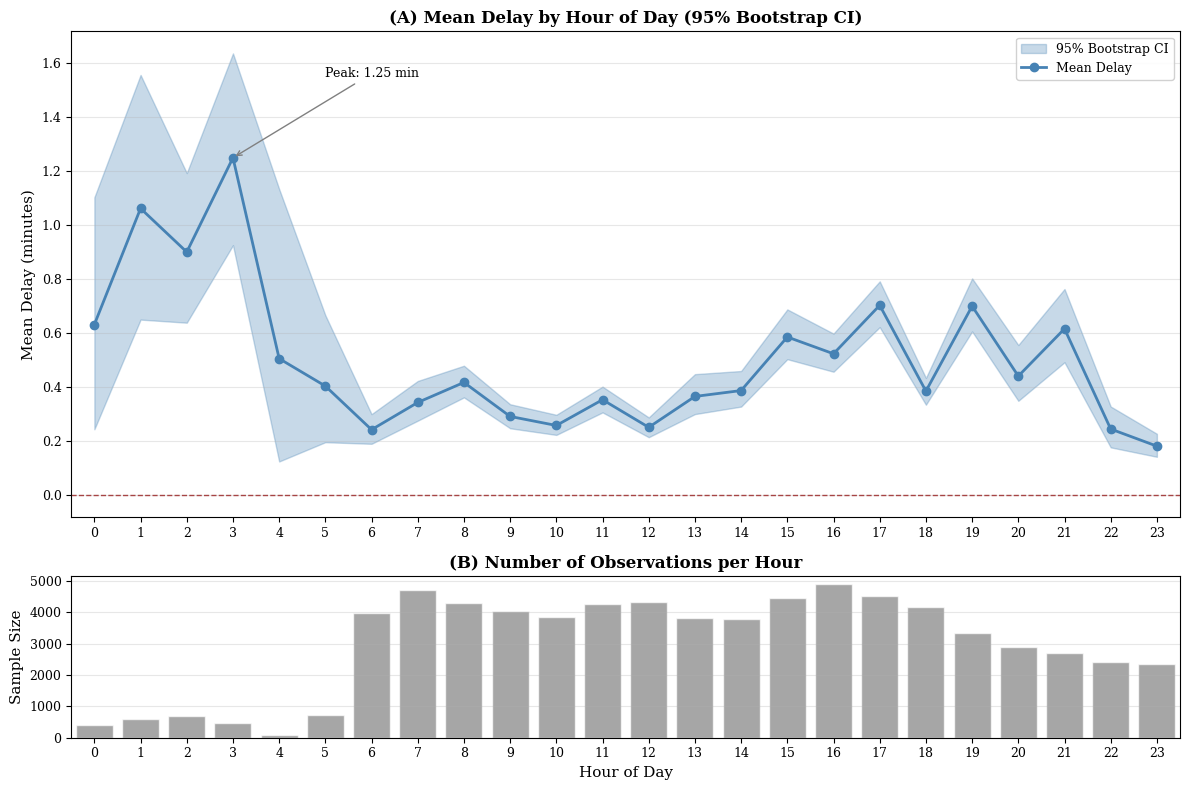


HYPOTHESIS 4 SUMMARY: Do delays change throughout the day?
  Peak delay hour: 3:00 with mean=1.25 min
  Lowest delay hour: 23:00 with mean=0.18 min
  Difference: 1.07 min

  Hourly breakdown:
    00:00 - mean=0.63 min, late=13.7%, n=402.0
    01:00 - mean=1.06 min, late=36.8%, n=585.0
    02:00 - mean=0.90 min, late=37.8%, n=706.0
    03:00 - mean=1.25 min, late=36.7%, n=480.0
    04:00 - mean=0.50 min, late=20.5%, n=73.0
    05:00 - mean=0.40 min, late=9.2%, n=730.0
    06:00 - mean=0.24 min, late=8.0%, n=3,974.0
    07:00 - mean=0.34 min, late=11.8%, n=4,704.0
    08:00 - mean=0.42 min, late=14.3%, n=4,291.0
    09:00 - mean=0.29 min, late=10.6%, n=4,026.0
    10:00 - mean=0.26 min, late=13.0%, n=3,843.0
    11:00 - mean=0.35 min, late=13.6%, n=4,250.0
    12:00 - mean=0.25 min, late=12.2%, n=4,322.0
    13:00 - mean=0.36 min, late=13.1%, n=3,805.0
    14:00 - mean=0.39 min, late=15.1%, n=3,791.0
    15:00 - mean=0.58 min, late=17.3%, n=4,450.0
    16:00 - mean=0.52 min, late=16.9%,

In [53]:
# =============================================================================
# HYPOTHESIS 4: "Die Größe der Verspätungen ändern sich im Verlauf des Tages"
# Figure: Mean delay by hour with bootstrap CI + sample size bars
# =============================================================================
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

fig, axes = plt.subplots(2, 1, figsize=(12, 8), gridspec_kw={'height_ratios': [3, 1]})

df = all_departure_data.copy()
df['hour'] = pd.to_datetime(df['planned_time']).dt.hour

def bootstrap_mean_ci(x, n_boot=1000, seed=42):
    rng = np.random.default_rng(seed)
    x = np.array(x)
    n = len(x)
    if n == 0:
        return np.nan, np.nan, np.nan
    boot_means = [np.mean(rng.choice(x, size=n, replace=True)) for _ in range(n_boot)]
    return np.mean(x), np.percentile(boot_means, 2.5), np.percentile(boot_means, 97.5)

# Compute statistics per hour
hourly_stats = []
for hour in range(24):
    delays = df.loc[df['hour'] == hour, 'delay_minutes'].dropna().values
    if len(delays) < 10:
        hourly_stats.append({'hour': hour, 'mean': np.nan, 'median': np.nan,
                            'ci_low': np.nan, 'ci_high': np.nan, 'n': len(delays), 'late_rate': np.nan})
        continue
    mean_val, ci_low, ci_high = bootstrap_mean_ci(delays)
    hourly_stats.append({
        'hour': hour,
        'mean': mean_val,
        'median': np.median(delays),
        'ci_low': ci_low,
        'ci_high': ci_high,
        'n': len(delays),
        'late_rate': np.mean(delays > 0)
    })

hourly_df = pd.DataFrame(hourly_stats)

# --- Panel A: Mean delay by hour with CI ---
ax = axes[0]

# Plot mean with confidence band
valid_mask = hourly_df['mean'].notna()
hours_valid = hourly_df.loc[valid_mask, 'hour'].values
means_valid = hourly_df.loc[valid_mask, 'mean'].values
ci_low_valid = hourly_df.loc[valid_mask, 'ci_low'].values
ci_high_valid = hourly_df.loc[valid_mask, 'ci_high'].values

ax.fill_between(hours_valid, ci_low_valid, ci_high_valid, alpha=0.3, color='steelblue', label='95% Bootstrap CI')
ax.plot(hours_valid, means_valid, 'o-', color='steelblue', linewidth=2, markersize=6, label='Mean Delay')

ax.axhline(0, color='darkred', linestyle='--', linewidth=1, alpha=0.7)
ax.set_xlabel('')
ax.set_ylabel('Mean Delay (minutes)')
ax.set_title('(A) Mean Delay by Hour of Day (95% Bootstrap CI)', fontweight='bold')
ax.set_xticks(range(24))
ax.set_xlim(-0.5, 23.5)
ax.legend(loc='upper right', framealpha=0.9)
ax.grid(axis='y', alpha=0.3)

# Annotate peak and trough
peak_hour = hourly_df.loc[hourly_df['mean'].idxmax()]
trough_hour = hourly_df.loc[hourly_df['mean'].idxmin()]
ax.annotate(f'Peak: {peak_hour["mean"]:.2f} min',
            xy=(peak_hour['hour'], peak_hour['mean']),
            xytext=(peak_hour['hour'] + 2, peak_hour['mean'] + 0.3),
            fontsize=9, arrowprops=dict(arrowstyle='->', color='gray'))

# --- Panel B: Sample size per hour ---
ax = axes[1]
ax.bar(hourly_df['hour'], hourly_df['n'], color='gray', edgecolor='white', alpha=0.7)
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Sample Size')
ax.set_title('(B) Number of Observations per Hour', fontweight='bold')
ax.set_xticks(range(24))
ax.set_xlim(-0.5, 23.5)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('fig4_hypothesis4_hourly.pdf', dpi=300, bbox_inches='tight')
plt.savefig('fig4_hypothesis4_hourly.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "="*70)
print("HYPOTHESIS 4 SUMMARY: Do delays change throughout the day?")
print("="*70)
print(f"  Peak delay hour: {int(peak_hour['hour'])}:00 with mean={peak_hour['mean']:.2f} min")
print(f"  Lowest delay hour: {int(trough_hour['hour'])}:00 with mean={trough_hour['mean']:.2f} min")
print(f"  Difference: {peak_hour['mean'] - trough_hour['mean']:.2f} min")
print(f"\n  Hourly breakdown:")
for _, row in hourly_df.iterrows():
    if pd.notna(row['mean']):
        print(f"    {int(row['hour']):02d}:00 - mean={row['mean']:.2f} min, late={100*row['late_rate']:.1f}%, n={row['n']:,}")
print("="*70)

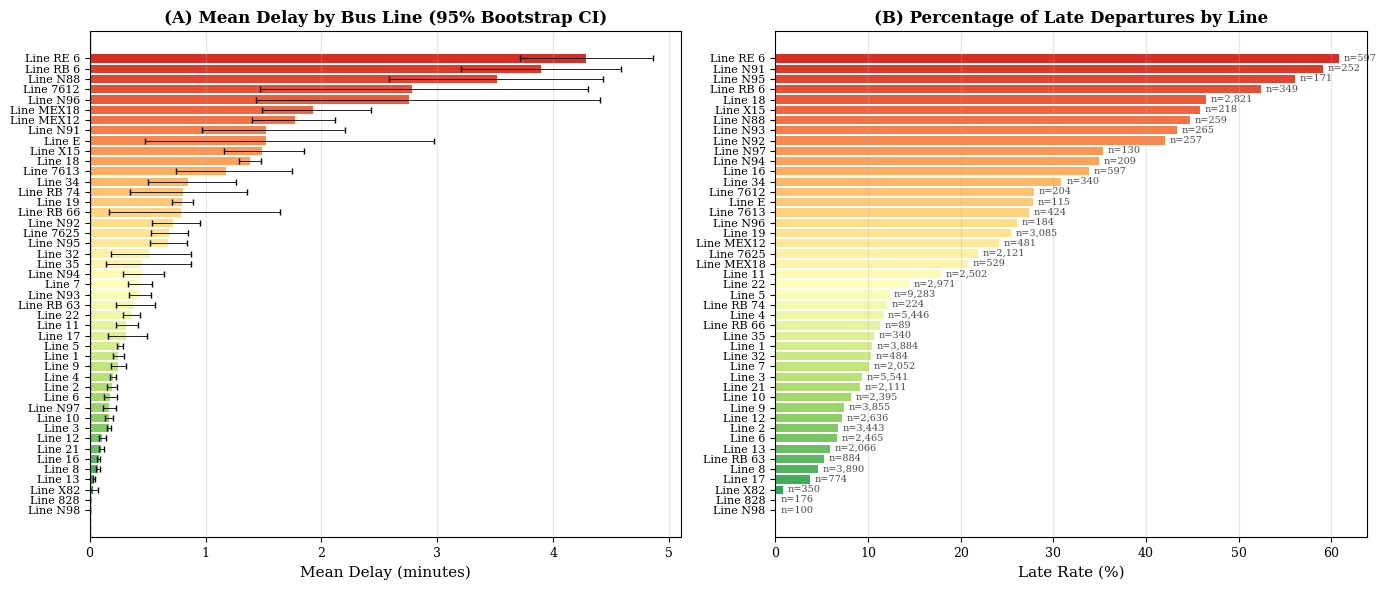


HYPOTHESIS 5 SUMMARY: Do delays depend on bus lines?
  Lines analyzed (n≥100): 45
  Range of mean delays: 0.00 to 4.28 min

  Top 5 most delayed lines:
    - Line RE 6: mean=4.28 min, late=60.8%, n=597
    - Line RB 6: mean=3.89 min, late=52.4%, n=349
    - Line N88: mean=3.51 min, late=44.8%, n=259
    - Line 7612: mean=2.78 min, late=27.9%, n=204
    - Line N96: mean=2.76 min, late=26.1%, n=184

  Top 5 most punctual lines:
    - Line N98: mean=0.00 min, late=0.0%, n=100
    - Line 828: mean=0.00 min, late=0.0%, n=176
    - Line X82: mean=0.03 min, late=0.9%, n=350
    - Line 13: mean=0.03 min, late=5.9%, n=2,066
    - Line 8: mean=0.07 min, late=4.6%, n=3,890


In [54]:
# =============================================================================
# HYPOTHESIS 5: "Die Verspätungen hängen von den Linien ab"
# Figure: Mean delay by line with bootstrap CI
# =============================================================================
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

df = all_departure_data.copy()

# Filter lines with sufficient data (use 'line_name' column)
line_counts = df['line_name'].value_counts()
valid_lines = line_counts[line_counts >= 100].index
df_filtered = df[df['line_name'].isin(valid_lines)]

def bootstrap_mean_ci(x, n_boot=1000, seed=42):
    rng = np.random.default_rng(seed)
    x = np.array(x)
    n = len(x)
    if n == 0:
        return np.nan, np.nan, np.nan
    boot_means = [np.mean(rng.choice(x, size=n, replace=True)) for _ in range(n_boot)]
    return np.mean(x), np.percentile(boot_means, 2.5), np.percentile(boot_means, 97.5)

# Compute statistics per line
line_stats = []
for line in valid_lines:
    delays = df_filtered.loc[df_filtered['line_name'] == line, 'delay_minutes'].dropna().values
    if len(delays) < 50:
        continue
    mean_val, ci_low, ci_high = bootstrap_mean_ci(delays)
    line_stats.append({
        'line': str(line),
        'n': len(delays),
        'mean': mean_val,
        'median': np.median(delays),
        'ci_low': ci_low,
        'ci_high': ci_high,
        'late_rate': np.mean(delays > 0)
    })

# Sort ASCENDING so highest delay is at TOP (barh puts y=0 at bottom)
line_df = pd.DataFrame(line_stats).sort_values('mean', ascending=True)

# --- Panel A: All lines sorted by mean delay ---
ax = axes[0]
y_pos = np.arange(len(line_df))

# Color gradient: green at bottom (low delay), red at top (high delay)
# RdYlGn: 0=red, 1=green. We want bottom=green, top=red
# Since y_pos increases upward, use RdYlGn_r (reversed: 0=green, 1=red)
colors_a = plt.cm.RdYlGn_r(np.linspace(0.1, 0.9, len(line_df)))

ax.barh(y_pos, line_df['mean'].values,
        xerr=[line_df['mean'].values - line_df['ci_low'].values,
              line_df['ci_high'].values - line_df['mean'].values],
        color=colors_a, capsize=2, error_kw={'linewidth': 0.6})

ax.set_yticks(y_pos)
ax.set_yticklabels([f"Line {l}" for l in line_df['line'].values], fontsize=8)
ax.axvline(0, color='darkred', linestyle='--', linewidth=1, alpha=0.7)
ax.set_xlabel('Mean Delay (minutes)')
ax.set_ylabel('')
ax.set_title('(A) Mean Delay by Bus Line (95% Bootstrap CI)', fontweight='bold')
ax.grid(axis='x', alpha=0.3)

# --- Panel B: Late rate comparison ---
ax = axes[1]
# Sort ASCENDING so highest late rate is at TOP
line_df_sorted_late = line_df.sort_values('late_rate', ascending=True)
y_pos = np.arange(len(line_df_sorted_late))

# Same logic: green at bottom (low late rate), red at top (high late rate)
colors_b = plt.cm.RdYlGn_r(np.linspace(0.1, 0.9, len(line_df_sorted_late)))

ax.barh(y_pos, line_df_sorted_late['late_rate'].values * 100, color=colors_b)

ax.set_yticks(y_pos)
ax.set_yticklabels([f"Line {l}" for l in line_df_sorted_late['line'].values], fontsize=8)
ax.set_xlabel('Late Rate (%)')
ax.set_ylabel('')
ax.set_title('(B) Percentage of Late Departures by Line', fontweight='bold')
ax.grid(axis='x', alpha=0.3)

# Add sample size annotations
for i, (_, row) in enumerate(line_df_sorted_late.iterrows()):
    ax.text(row['late_rate'] * 100 + 0.5, i, f'n={row["n"]:,}', va='center', fontsize=7, alpha=0.7)

plt.tight_layout()
plt.savefig('fig5_hypothesis5_lines.pdf', dpi=300, bbox_inches='tight')
plt.savefig('fig5_hypothesis5_lines.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "="*70)
print("HYPOTHESIS 5 SUMMARY: Do delays depend on bus lines?")
print("="*70)
print(f"  Lines analyzed (n≥100): {len(line_df)}")
print(f"  Range of mean delays: {line_df['mean'].min():.2f} to {line_df['mean'].max():.2f} min")
print(f"\n  Top 5 most delayed lines:")
for _, row in line_df.tail(5).iloc[::-1].iterrows():
    print(f"    - Line {row['line']}: mean={row['mean']:.2f} min, late={100*row['late_rate']:.1f}%, n={row['n']:,}")
print(f"\n  Top 5 most punctual lines:")
for _, row in line_df.head(5).iterrows():
    print(f"    - Line {row['line']}: mean={row['mean']:.2f} min, late={100*row['late_rate']:.1f}%, n={row['n']:,}")
print("="*70)

/var/folders/n4/d1s6w7jn7jg1x7dnv_c53jd40000gn/T/ipykernel_30745/1347422845.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['temp_bin'] = pd.cut(df_clean['temperature'], bins=temp_bins)
/var/folders/n4/d1s6w7jn7jg1x7dnv_c53jd40000gn/T/ipykernel_30745/1347422845.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['temp_cat'] = pd.cut(df_clean['temperature'],


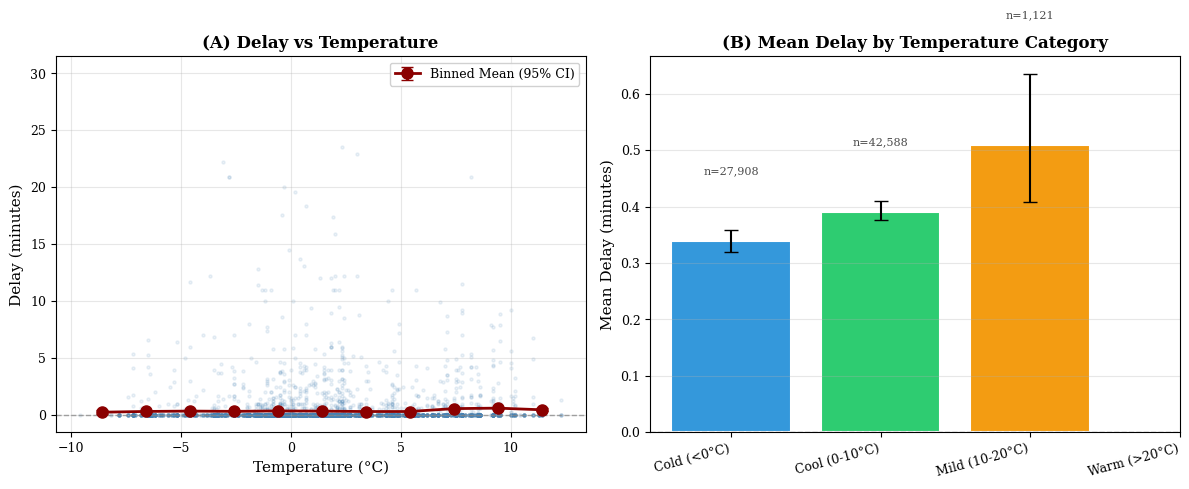


HYPOTHESIS 6 SUMMARY: Do delays depend on temperature?
  Cold (<0°C): mean=0.34 min, n=27,908
  Cool (0-10°C): mean=0.39 min, n=42,588
  Mild (10-20°C): mean=0.51 min, n=1,121


In [55]:
# =============================================================================
# HYPOTHESIS 6: "Die Verspätungen hängen von der Temperatur ab"
# Figure: Scatter with binned means + bootstrap CI
# =============================================================================
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

df = all_departure_data.copy()

# Remove extreme outliers for visualization
df_clean = df[(df['delay_minutes'] >= -10) & (df['delay_minutes'] <= 30)]

# --- Panel A: Scatter with density + binned means ---
ax = axes[0]

# Sample for scatter (too many points otherwise)
sample_size = min(5000, len(df_clean))
df_sample = df_clean.sample(n=sample_size, random_state=42)

ax.scatter(df_sample['temperature'], df_sample['delay_minutes'],
           alpha=0.1, s=5, color='steelblue', rasterized=True)

# Bin temperatures and compute mean delay per bin
temp_bins = np.arange(df_clean['temperature'].min(),
                      df_clean['temperature'].max() + 2, 2)
df_clean['temp_bin'] = pd.cut(df_clean['temperature'], bins=temp_bins)

def bootstrap_mean_ci(x, n_boot=500, seed=42):
    rng = np.random.default_rng(seed)
    x = np.array(x)
    n = len(x)
    if n < 10:
        return np.nan, np.nan, np.nan
    boot_means = [np.mean(rng.choice(x, size=n, replace=True)) for _ in range(n_boot)]
    return np.mean(x), np.percentile(boot_means, 2.5), np.percentile(boot_means, 97.5)

bin_stats = []
for bin_label in df_clean['temp_bin'].dropna().unique():
    delays = df_clean.loc[df_clean['temp_bin'] == bin_label, 'delay_minutes'].dropna().values
    if len(delays) < 30:
        continue
    mean_val, ci_low, ci_high = bootstrap_mean_ci(delays)
    bin_stats.append({
        'temp_mid': bin_label.mid,
        'mean': mean_val,
        'ci_low': ci_low,
        'ci_high': ci_high,
        'n': len(delays)
    })

bin_df = pd.DataFrame(bin_stats).sort_values('temp_mid')

# Plot binned means with CI
ax.errorbar(bin_df['temp_mid'], bin_df['mean'],
            yerr=[bin_df['mean'] - bin_df['ci_low'], bin_df['ci_high'] - bin_df['mean']],
            fmt='o-', color='darkred', linewidth=2, markersize=8, capsize=4,
            label='Binned Mean (95% CI)', zorder=5)

ax.axhline(0, color='gray', linestyle='--', linewidth=1, alpha=0.7)
ax.set_xlabel('Temperature (°C)')
ax.set_ylabel('Delay (minutes)')
ax.set_title('(A) Delay vs Temperature', fontweight='bold')
ax.legend(loc='upper right', framealpha=0.9)
ax.grid(alpha=0.3)

# --- Panel B: Temperature categories comparison ---
ax = axes[1]

# Create temperature categories
df_clean['temp_cat'] = pd.cut(df_clean['temperature'],
                               bins=[-np.inf, 0, 10, 20, np.inf],
                               labels=['Cold (<0°C)', 'Cool (0-10°C)', 'Mild (10-20°C)', 'Warm (>20°C)'])

cat_stats = []
for cat in ['Cold (<0°C)', 'Cool (0-10°C)', 'Mild (10-20°C)', 'Warm (>20°C)']:
    delays = df_clean.loc[df_clean['temp_cat'] == cat, 'delay_minutes'].dropna().values
    if len(delays) < 30:
        cat_stats.append({'cat': cat, 'mean': np.nan, 'ci_low': np.nan, 'ci_high': np.nan, 'n': 0})
        continue
    mean_val, ci_low, ci_high = bootstrap_mean_ci(delays)
    cat_stats.append({
        'cat': cat,
        'mean': mean_val,
        'ci_low': ci_low,
        'ci_high': ci_high,
        'n': len(delays),
        'late_rate': np.mean(delays > 0)
    })

cat_df = pd.DataFrame(cat_stats)

x_pos = np.arange(len(cat_df))
colors = ['#3498db', '#2ecc71', '#f39c12', '#e74c3c']

bars = ax.bar(x_pos, cat_df['mean'].values, color=colors, edgecolor='white', linewidth=1.5)
ax.errorbar(x_pos, cat_df['mean'].values,
            yerr=[cat_df['mean'].values - cat_df['ci_low'].values,
                  cat_df['ci_high'].values - cat_df['mean'].values],
            fmt='none', color='black', capsize=5, linewidth=1.5)

ax.set_xticks(x_pos)
ax.set_xticklabels(cat_df['cat'].values, rotation=15, ha='right')
ax.axhline(0, color='gray', linestyle='--', linewidth=1, alpha=0.7)
ax.set_ylabel('Mean Delay (minutes)')
ax.set_title('(B) Mean Delay by Temperature Category', fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Add sample size labels
for i, (_, row) in enumerate(cat_df.iterrows()):
    if pd.notna(row['mean']):
        ax.text(i, row['ci_high'] + 0.1, f'n={row["n"]:,}', ha='center', fontsize=8, alpha=0.7)

plt.tight_layout()
plt.savefig('fig6_hypothesis6_temperature.pdf', dpi=300, bbox_inches='tight')
plt.savefig('fig6_hypothesis6_temperature.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "="*70)
print("HYPOTHESIS 6 SUMMARY: Do delays depend on temperature?")
print("="*70)
for _, row in cat_df.iterrows():
    if pd.notna(row['mean']):
        print(f"  {row['cat']}: mean={row['mean']:.2f} min, n={row['n']:,}")
print("="*70)

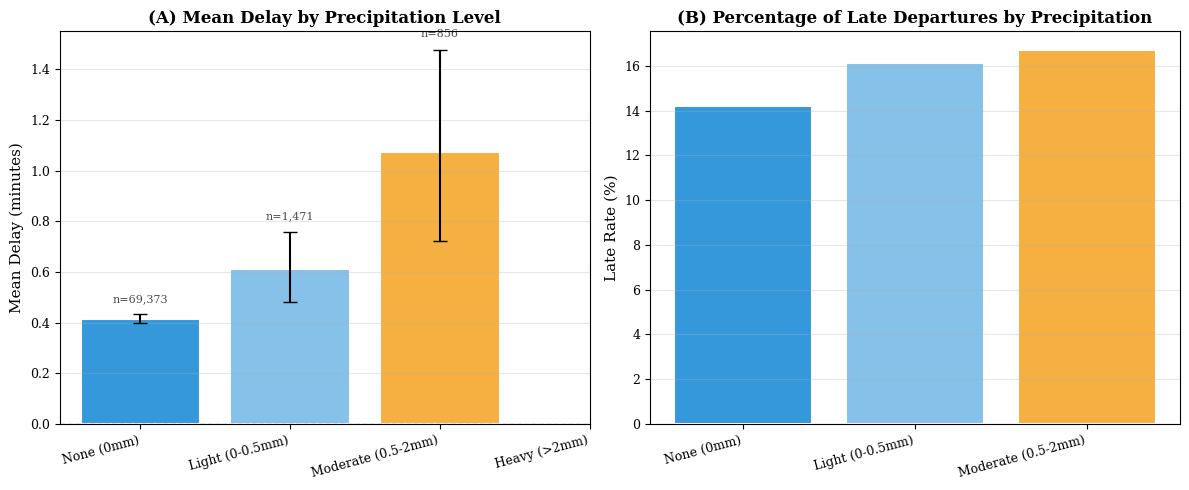


HYPOTHESIS 7 SUMMARY: Do delays depend on precipitation?
  None (0mm): mean=0.41 min, late=14.2%, n=69,373
  Light (0-0.5mm): mean=0.61 min, late=16.1%, n=1,471
  Moderate (0.5-2mm): mean=1.07 min, late=16.7%, n=856


In [56]:
# =============================================================================
# HYPOTHESIS 7: "Die Verspätungen hängen vom Niederschlag ab"
# Figure: Precipitation categories with bootstrap CI
# =============================================================================
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

df = all_departure_data.copy()

def bootstrap_mean_ci(x, n_boot=1000, seed=42):
    rng = np.random.default_rng(seed)
    x = np.array(x)
    n = len(x)
    if n < 10:
        return np.nan, np.nan, np.nan
    boot_means = [np.mean(rng.choice(x, size=n, replace=True)) for _ in range(n_boot)]
    return np.mean(x), np.percentile(boot_means, 2.5), np.percentile(boot_means, 97.5)

# --- Panel A: Precipitation categories ---
ax = axes[0]

# Create precipitation categories
df['precip_cat'] = pd.cut(df['precipitation_mm'],
                          bins=[-0.01, 0, 0.5, 2, np.inf],
                          labels=['None (0mm)', 'Light (0-0.5mm)', 'Moderate (0.5-2mm)', 'Heavy (>2mm)'])

cat_stats = []
for cat in ['None (0mm)', 'Light (0-0.5mm)', 'Moderate (0.5-2mm)', 'Heavy (>2mm)']:
    delays = df.loc[df['precip_cat'] == cat, 'delay_minutes'].dropna().values
    if len(delays) < 30:
        cat_stats.append({'cat': cat, 'mean': np.nan, 'ci_low': np.nan, 'ci_high': np.nan, 'n': 0, 'late_rate': np.nan})
        continue
    mean_val, ci_low, ci_high = bootstrap_mean_ci(delays)
    cat_stats.append({
        'cat': cat,
        'mean': mean_val,
        'ci_low': ci_low,
        'ci_high': ci_high,
        'n': len(delays),
        'late_rate': np.mean(delays > 0)
    })

cat_df = pd.DataFrame(cat_stats)

x_pos = np.arange(len(cat_df))
colors = ['#3498db', '#85c1e9', '#f5b041', '#e74c3c']

bars = ax.bar(x_pos, cat_df['mean'].values, color=colors, edgecolor='white', linewidth=1.5)
ax.errorbar(x_pos, cat_df['mean'].values,
            yerr=[cat_df['mean'].values - cat_df['ci_low'].values,
                  cat_df['ci_high'].values - cat_df['mean'].values],
            fmt='none', color='black', capsize=5, linewidth=1.5)

ax.set_xticks(x_pos)
ax.set_xticklabels(cat_df['cat'].values, rotation=15, ha='right')
ax.axhline(0, color='gray', linestyle='--', linewidth=1, alpha=0.7)
ax.set_ylabel('Mean Delay (minutes)')
ax.set_title('(A) Mean Delay by Precipitation Level', fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Add sample size labels
for i, (_, row) in enumerate(cat_df.iterrows()):
    if pd.notna(row['mean']):
        ax.text(i, row['ci_high'] + 0.05, f'n={row["n"]:,}', ha='center', fontsize=8, alpha=0.7)

# --- Panel B: Late rate by precipitation ---
ax = axes[1]

valid_cats = cat_df[cat_df['late_rate'].notna()]
x_pos = np.arange(len(valid_cats))

bars = ax.bar(x_pos, valid_cats['late_rate'].values * 100, color=colors[:len(valid_cats)],
              edgecolor='white', linewidth=1.5)

ax.set_xticks(x_pos)
ax.set_xticklabels(valid_cats['cat'].values, rotation=15, ha='right')
ax.set_ylabel('Late Rate (%)')
ax.set_title('(B) Percentage of Late Departures by Precipitation', fontweight='bold')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('fig7_hypothesis7_precipitation.pdf', dpi=300, bbox_inches='tight')
plt.savefig('fig7_hypothesis7_precipitation.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "="*70)
print("HYPOTHESIS 7 SUMMARY: Do delays depend on precipitation?")
print("="*70)
for _, row in cat_df.iterrows():
    if pd.notna(row['mean']):
        print(f"  {row['cat']}: mean={row['mean']:.2f} min, late={100*row['late_rate']:.1f}%, n={row['n']:,}")
print("="*70)

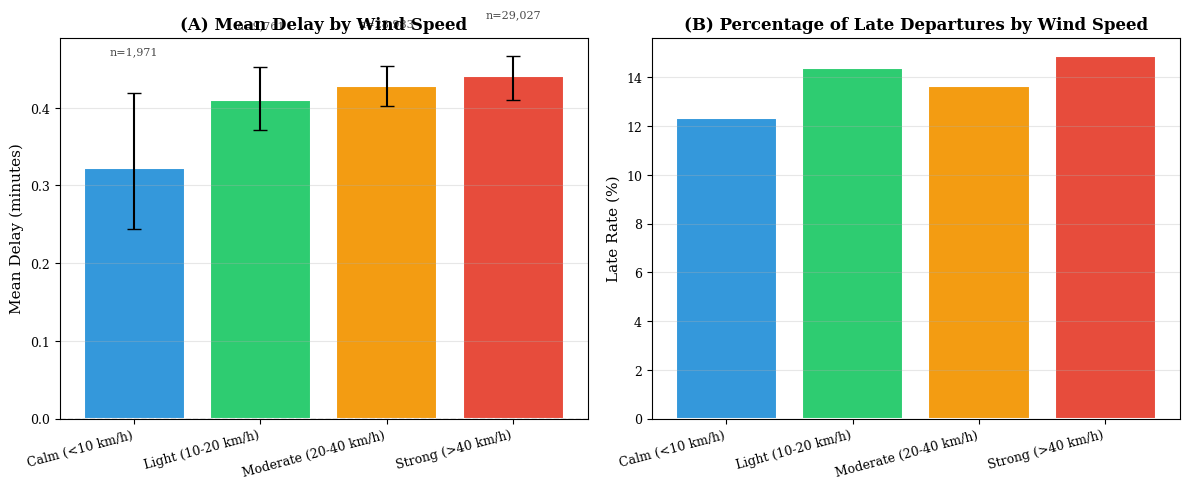


HYPOTHESIS 8 SUMMARY: Do delays depend on wind speed?
  Calm (<10 km/h): mean=0.32 min, late=12.3%, n=1,971
  Light (10-20 km/h): mean=0.41 min, late=14.4%, n=9,761
  Moderate (20-40 km/h): mean=0.43 min, late=13.6%, n=28,983
  Strong (>40 km/h): mean=0.44 min, late=14.9%, n=29,027


In [57]:
# =============================================================================
# HYPOTHESIS 8: "Die Verspätungen hängen von der Windgeschwindigkeit ab"
# Figure: Wind speed categories with bootstrap CI
# =============================================================================
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

df = all_departure_data.copy()

def bootstrap_mean_ci(x, n_boot=1000, seed=42):
    rng = np.random.default_rng(seed)
    x = np.array(x)
    n = len(x)
    if n < 10:
        return np.nan, np.nan, np.nan
    boot_means = [np.mean(rng.choice(x, size=n, replace=True)) for _ in range(n_boot)]
    return np.mean(x), np.percentile(boot_means, 2.5), np.percentile(boot_means, 97.5)

# --- Panel A: Wind speed categories ---
ax = axes[0]

# Create wind speed categories (convert km/h thresholds to m/s: divide by 3.6)
# 10 km/h ≈ 2.8 m/s, 20 km/h ≈ 5.6 m/s, 40 km/h ≈ 11.1 m/s
df['wind_cat'] = pd.cut(df['wind_speed_ms'],
                        bins=[-0.01, 2.8, 5.6, 11.1, np.inf],
                        labels=['Calm (<10 km/h)', 'Light (10-20 km/h)', 'Moderate (20-40 km/h)', 'Strong (>40 km/h)'])

cat_stats = []
for cat in ['Calm (<10 km/h)', 'Light (10-20 km/h)', 'Moderate (20-40 km/h)', 'Strong (>40 km/h)']:
    delays = df.loc[df['wind_cat'] == cat, 'delay_minutes'].dropna().values
    if len(delays) < 30:
        cat_stats.append({'cat': cat, 'mean': np.nan, 'ci_low': np.nan, 'ci_high': np.nan, 'n': 0, 'late_rate': np.nan})
        continue
    mean_val, ci_low, ci_high = bootstrap_mean_ci(delays)
    cat_stats.append({
        'cat': cat,
        'mean': mean_val,
        'ci_low': ci_low,
        'ci_high': ci_high,
        'n': len(delays),
        'late_rate': np.mean(delays > 0)
    })

cat_df = pd.DataFrame(cat_stats)

valid_cats = cat_df[cat_df['mean'].notna()]
x_pos = np.arange(len(valid_cats))
colors = ['#3498db', '#2ecc71', '#f39c12', '#e74c3c']

bars = ax.bar(x_pos, valid_cats['mean'].values, color=colors[:len(valid_cats)], edgecolor='white', linewidth=1.5)
ax.errorbar(x_pos, valid_cats['mean'].values,
            yerr=[valid_cats['mean'].values - valid_cats['ci_low'].values,
                  valid_cats['ci_high'].values - valid_cats['mean'].values],
            fmt='none', color='black', capsize=5, linewidth=1.5)

ax.set_xticks(x_pos)
ax.set_xticklabels(valid_cats['cat'].values, rotation=15, ha='right')
ax.axhline(0, color='gray', linestyle='--', linewidth=1, alpha=0.7)
ax.set_ylabel('Mean Delay (minutes)')
ax.set_title('(A) Mean Delay by Wind Speed', fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Add sample size labels
for i, (_, row) in enumerate(valid_cats.iterrows()):
    ax.text(i, row['ci_high'] + 0.05, f'n={row["n"]:,}', ha='center', fontsize=8, alpha=0.7)

# --- Panel B: Late rate by wind speed ---
ax = axes[1]

bars = ax.bar(x_pos, valid_cats['late_rate'].values * 100, color=colors[:len(valid_cats)],
              edgecolor='white', linewidth=1.5)

ax.set_xticks(x_pos)
ax.set_xticklabels(valid_cats['cat'].values, rotation=15, ha='right')
ax.set_ylabel('Late Rate (%)')
ax.set_title('(B) Percentage of Late Departures by Wind Speed', fontweight='bold')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('fig8_hypothesis8_wind.pdf', dpi=300, bbox_inches='tight')
plt.savefig('fig8_hypothesis8_wind.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "="*70)
print("HYPOTHESIS 8 SUMMARY: Do delays depend on wind speed?")
print("="*70)
for _, row in cat_df.iterrows():
    if pd.notna(row['mean']):
        print(f"  {row['cat']}: mean={row['mean']:.2f} min, late={100*row['late_rate']:.1f}%, n={row['n']:,}")
print("="*70)

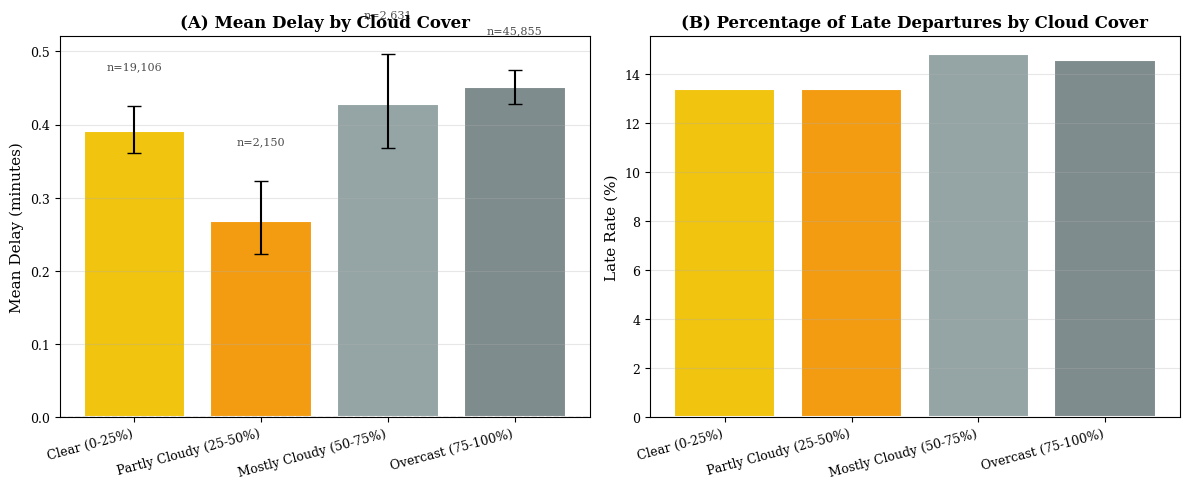


HYPOTHESIS 9 SUMMARY: Do delays depend on cloud cover?
  Clear (0-25%): mean=0.39 min, late=13.4%, n=19,106
  Partly Cloudy (25-50%): mean=0.27 min, late=13.4%, n=2,150
  Mostly Cloudy (50-75%): mean=0.43 min, late=14.8%, n=2,631
  Overcast (75-100%): mean=0.45 min, late=14.6%, n=45,855


In [58]:
# =============================================================================
# HYPOTHESIS 9: "Die Verspätungen hängen von der Bewölkung ab"
# Figure: Cloud cover categories with bootstrap CI
# =============================================================================
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

df = all_departure_data.copy()

def bootstrap_mean_ci(x, n_boot=1000, seed=42):
    rng = np.random.default_rng(seed)
    x = np.array(x)
    n = len(x)
    if n < 10:
        return np.nan, np.nan, np.nan
    boot_means = [np.mean(rng.choice(x, size=n, replace=True)) for _ in range(n_boot)]
    return np.mean(x), np.percentile(boot_means, 2.5), np.percentile(boot_means, 97.5)

# --- Panel A: Cloud cover categories ---
ax = axes[0]

# Create cloud cover categories
df['cloud_cat'] = pd.cut(df['cloud_cover'],
                         bins=[-0.01, 25, 50, 75, 100.01],
                         labels=['Clear (0-25%)', 'Partly Cloudy (25-50%)', 'Mostly Cloudy (50-75%)', 'Overcast (75-100%)'])

cat_stats = []
for cat in ['Clear (0-25%)', 'Partly Cloudy (25-50%)', 'Mostly Cloudy (50-75%)', 'Overcast (75-100%)']:
    delays = df.loc[df['cloud_cat'] == cat, 'delay_minutes'].dropna().values
    if len(delays) < 30:
        cat_stats.append({'cat': cat, 'mean': np.nan, 'ci_low': np.nan, 'ci_high': np.nan, 'n': 0, 'late_rate': np.nan})
        continue
    mean_val, ci_low, ci_high = bootstrap_mean_ci(delays)
    cat_stats.append({
        'cat': cat,
        'mean': mean_val,
        'ci_low': ci_low,
        'ci_high': ci_high,
        'n': len(delays),
        'late_rate': np.mean(delays > 0)
    })

cat_df = pd.DataFrame(cat_stats)

valid_cats = cat_df[cat_df['mean'].notna()]
x_pos = np.arange(len(valid_cats))
colors = ['#f1c40f', '#f39c12', '#95a5a6', '#7f8c8d']

bars = ax.bar(x_pos, valid_cats['mean'].values, color=colors[:len(valid_cats)], edgecolor='white', linewidth=1.5)
ax.errorbar(x_pos, valid_cats['mean'].values,
            yerr=[valid_cats['mean'].values - valid_cats['ci_low'].values,
                  valid_cats['ci_high'].values - valid_cats['mean'].values],
            fmt='none', color='black', capsize=5, linewidth=1.5)

ax.set_xticks(x_pos)
ax.set_xticklabels(valid_cats['cat'].values, rotation=15, ha='right')
ax.axhline(0, color='gray', linestyle='--', linewidth=1, alpha=0.7)
ax.set_ylabel('Mean Delay (minutes)')
ax.set_title('(A) Mean Delay by Cloud Cover', fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Add sample size labels
for i, (_, row) in enumerate(valid_cats.iterrows()):
    ax.text(i, row['ci_high'] + 0.05, f'n={row["n"]:,}', ha='center', fontsize=8, alpha=0.7)

# --- Panel B: Late rate by cloud cover ---
ax = axes[1]

bars = ax.bar(x_pos, valid_cats['late_rate'].values * 100, color=colors[:len(valid_cats)],
              edgecolor='white', linewidth=1.5)

ax.set_xticks(x_pos)
ax.set_xticklabels(valid_cats['cat'].values, rotation=15, ha='right')
ax.set_ylabel('Late Rate (%)')
ax.set_title('(B) Percentage of Late Departures by Cloud Cover', fontweight='bold')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('fig9_hypothesis9_clouds.pdf', dpi=300, bbox_inches='tight')
plt.savefig('fig9_hypothesis9_clouds.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "="*70)
print("HYPOTHESIS 9 SUMMARY: Do delays depend on cloud cover?")
print("="*70)
for _, row in cat_df.iterrows():
    if pd.notna(row['mean']):
        print(f"  {row['cat']}: mean={row['mean']:.2f} min, late={100*row['late_rate']:.1f}%, n={row['n']:,}")
print("="*70)

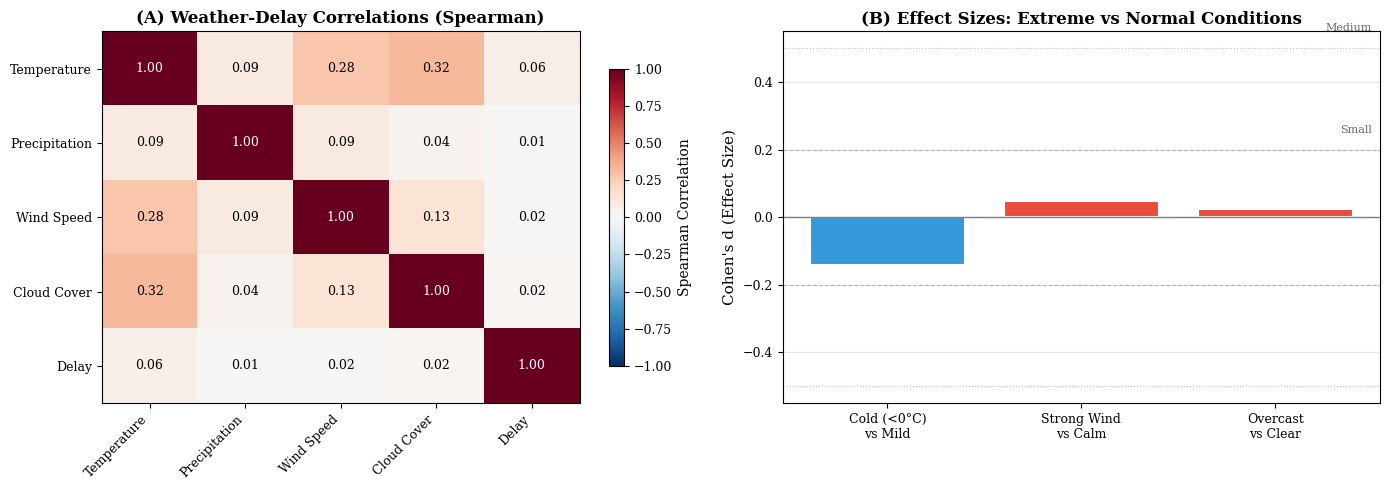


WEATHER ANALYSIS SUMMARY

Spearman correlations with delay:
  temperature: r = 0.056
  precipitation_mm: r = 0.012
  wind_speed_ms: r = 0.015
  cloud_cover: r = 0.017

Effect sizes (Cohen's d):
  Cold (<0°C) vs Mild: d = -0.141 (negligible)
  Strong Wind vs Calm: d = 0.049 (negligible)
  Overcast vs Clear: d = 0.024 (negligible)


In [59]:
# =============================================================================
# COMBINED WEATHER ANALYSIS: Correlation Heatmap & Feature Importance
# =============================================================================
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

df = all_departure_data.copy()

# --- Panel A: Correlation heatmap ---
ax = axes[0]

weather_cols = ['temperature', 'precipitation_mm', 'wind_speed_ms', 'cloud_cover', 'delay_minutes']
corr_df = df[weather_cols].dropna()

# Compute Spearman correlations (more robust to outliers)
corr_matrix = corr_df.corr(method='spearman')

# Create heatmap
im = ax.imshow(corr_matrix.values, cmap='RdBu_r', vmin=-1, vmax=1, aspect='auto')

# Add colorbar
cbar = plt.colorbar(im, ax=ax, shrink=0.8)
cbar.set_label('Spearman Correlation', fontsize=10)

# Labels
labels = ['Temperature', 'Precipitation', 'Wind Speed', 'Cloud Cover', 'Delay']
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=9)
ax.set_yticklabels(labels, fontsize=9)

# Add correlation values
for i in range(len(labels)):
    for j in range(len(labels)):
        val = corr_matrix.values[i, j]
        color = 'white' if abs(val) > 0.5 else 'black'
        ax.text(j, i, f'{val:.2f}', ha='center', va='center', color=color, fontsize=9)

ax.set_title('(A) Weather-Delay Correlations (Spearman)', fontweight='bold')

# --- Panel B: Effect sizes comparison ---
ax = axes[1]

# Calculate effect sizes (Cohen's d) for extreme vs normal conditions
def cohens_d(group1, group2):
    n1, n2 = len(group1), len(group2)
    var1, var2 = np.var(group1, ddof=1), np.var(group2, ddof=1)
    pooled_std = np.sqrt(((n1-1)*var1 + (n2-1)*var2) / (n1+n2-2))
    return (np.mean(group1) - np.mean(group2)) / pooled_std if pooled_std > 0 else 0

effects = []

# Temperature: Cold vs Mild
cold = df[df['temperature'] < 0]['delay_minutes'].dropna()
mild = df[(df['temperature'] >= 10) & (df['temperature'] <= 20)]['delay_minutes'].dropna()
if len(cold) > 30 and len(mild) > 30:
    effects.append({'factor': 'Cold (<0°C)\nvs Mild', 'd': cohens_d(cold, mild)})

# Precipitation: Heavy vs None
heavy_rain = df[df['precipitation_mm'] > 2]['delay_minutes'].dropna()
no_rain = df[df['precipitation_mm'] == 0]['delay_minutes'].dropna()
if len(heavy_rain) > 30 and len(no_rain) > 30:
    effects.append({'factor': 'Heavy Rain\nvs None', 'd': cohens_d(heavy_rain, no_rain)})

# Wind: Strong vs Calm (convert km/h thresholds to m/s: 40 km/h ≈ 11.1 m/s, 10 km/h ≈ 2.8 m/s)
strong_wind = df[df['wind_speed_ms'] > 11.1]['delay_minutes'].dropna()
calm = df[df['wind_speed_ms'] < 2.8]['delay_minutes'].dropna()
if len(strong_wind) > 30 and len(calm) > 30:
    effects.append({'factor': 'Strong Wind\nvs Calm', 'd': cohens_d(strong_wind, calm)})

# Cloud: Overcast vs Clear
overcast = df[df['cloud_cover'] > 75]['delay_minutes'].dropna()
clear = df[df['cloud_cover'] < 25]['delay_minutes'].dropna()
if len(overcast) > 30 and len(clear) > 30:
    effects.append({'factor': 'Overcast\nvs Clear', 'd': cohens_d(overcast, clear)})

effect_df = pd.DataFrame(effects)

if len(effect_df) > 0:
    x_pos = np.arange(len(effect_df))
    colors = ['#e74c3c' if d > 0 else '#3498db' for d in effect_df['d'].values]

    bars = ax.bar(x_pos, effect_df['d'].values, color=colors, edgecolor='white', linewidth=1.5)

    ax.set_xticks(x_pos)
    ax.set_xticklabels(effect_df['factor'].values, fontsize=9)
    ax.axhline(0, color='gray', linestyle='-', linewidth=1)
    ax.axhline(0.2, color='gray', linestyle='--', linewidth=0.8, alpha=0.5)
    ax.axhline(-0.2, color='gray', linestyle='--', linewidth=0.8, alpha=0.5)
    ax.axhline(0.5, color='gray', linestyle=':', linewidth=0.8, alpha=0.5)
    ax.axhline(-0.5, color='gray', linestyle=':', linewidth=0.8, alpha=0.5)

    ax.set_ylabel("Cohen's d (Effect Size)")
    ax.set_title('(B) Effect Sizes: Extreme vs Normal Conditions', fontweight='bold')
    ax.grid(axis='y', alpha=0.3)

    # Add effect size interpretation
    ax.text(len(effect_df)-0.5, 0.55, 'Medium', fontsize=8, alpha=0.6, ha='right')
    ax.text(len(effect_df)-0.5, 0.25, 'Small', fontsize=8, alpha=0.6, ha='right')

plt.tight_layout()
plt.savefig('fig10_weather_combined.pdf', dpi=300, bbox_inches='tight')
plt.savefig('fig10_weather_combined.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "="*70)
print("WEATHER ANALYSIS SUMMARY")
print("="*70)
print("\nSpearman correlations with delay:")
for col in ['temperature', 'precipitation_mm', 'wind_speed_ms', 'cloud_cover']:
    r = corr_matrix.loc[col, 'delay_minutes']
    print(f"  {col}: r = {r:.3f}")
print("\nEffect sizes (Cohen's d):")
for _, row in effect_df.iterrows():
    interpretation = 'negligible' if abs(row['d']) < 0.2 else 'small' if abs(row['d']) < 0.5 else 'medium' if abs(row['d']) < 0.8 else 'large'
    print(f"  {row['factor'].replace(chr(10), ' ')}: d = {row['d']:.3f} ({interpretation})")
print("="*70)

# Interactive D3.js Transit Network Graph

This section creates an interactive network visualization of the Tübingen transit system using D3.js.
- **Nodes**: Transit stops (sized by number of departures, colored by average delay)
- **Edges**: Direct connections between stops (width indicates frequency of trips)

The visualization is rendered as an HTML file that can be opened in any browser.

In [60]:
# =============================================================================
# D3.js Interactive Transit Network Graph (Tübingen Area Only)
# =============================================================================
import pandas as pd
import numpy as np
import json
from IPython.display import HTML, display

# Build nodes from stops with coordinates
stops_with_coords = all_trip_data[
    all_trip_data['latitude'].notna() & all_trip_data['longitude'].notna()
].copy()

# Filter to Tübingen area only (approximate bounding box for Tübingen city)
# Tübingen center: ~48.52°N, 9.05°E
# Use a tight bounding box to focus on the city
TUEBINGEN_LAT_MIN = 48.49
TUEBINGEN_LAT_MAX = 48.55
TUEBINGEN_LON_MIN = 8.99
TUEBINGEN_LON_MAX = 9.10

stops_with_coords = stops_with_coords[
    (stops_with_coords['latitude'] >= TUEBINGEN_LAT_MIN) &
    (stops_with_coords['latitude'] <= TUEBINGEN_LAT_MAX) &
    (stops_with_coords['longitude'] >= TUEBINGEN_LON_MIN) &
    (stops_with_coords['longitude'] <= TUEBINGEN_LON_MAX)
]

print(f"Filtered to Tübingen area: {stops_with_coords['stop_point_ref'].nunique()} stops")

# Aggregate stop statistics
stop_stats = stops_with_coords.groupby('stop_point_ref').agg({
    'stop_name': 'first',
    'latitude': 'first',
    'longitude': 'first',
    'departure_delay_minutes': ['mean', 'count']
}).reset_index()
stop_stats.columns = ['stop_id', 'stop_name', 'latitude', 'longitude', 'avg_delay', 'departure_count']

# Filter to stops with sufficient data
stop_stats = stop_stats[stop_stats['departure_count'] >= 10]

# Normalize coordinates to SVG space with better scaling
lat_min, lat_max = stop_stats['latitude'].min(), stop_stats['latitude'].max()
lon_min, lon_max = stop_stats['longitude'].min(), stop_stats['longitude'].max()

# Use larger canvas and more padding for better visibility
padding = 80
width = 1000
height = 800

# Scale coordinates - use aspect ratio correction for geographic coordinates
lat_range = lat_max - lat_min
lon_range = lon_max - lon_min

# Correct for latitude (1 degree longitude is shorter at higher latitudes)
aspect_ratio = np.cos(np.radians((lat_min + lat_max) / 2))
effective_lon_range = lon_range * aspect_ratio

# Scale to fit while maintaining aspect ratio
if lat_range / (height - 2*padding) > effective_lon_range / (width - 2*padding):
    # Height is the limiting factor
    scale = (height - 2*padding) / lat_range
else:
    # Width is the limiting factor
    scale = (width - 2*padding) / effective_lon_range

# Center the graph
center_x = width / 2
center_y = height / 2
center_lat = (lat_min + lat_max) / 2
center_lon = (lon_min + lon_max) / 2

stop_stats['x'] = center_x + (stop_stats['longitude'] - center_lon) * aspect_ratio * scale
stop_stats['y'] = center_y - (stop_stats['latitude'] - center_lat) * scale  # Flip y-axis

# Build edges from consecutive stops in trips (only within Tübingen)
tuebingen_stop_ids = set(stop_stats['stop_id'].values)
edges_list = []

for journey_ref in stops_with_coords['journey_ref'].unique():
    trip = stops_with_coords[stops_with_coords['journey_ref'] == journey_ref].sort_values('stop_sequence')
    stop_refs = trip['stop_point_ref'].values
    for i in range(len(stop_refs) - 1):
        source, target = stop_refs[i], stop_refs[i+1]
        if source in tuebingen_stop_ids and target in tuebingen_stop_ids:
            edges_list.append({'source': source, 'target': target})

# Aggregate edge frequencies
edges_df = pd.DataFrame(edges_list)
if len(edges_df) > 0:
    edge_counts = edges_df.groupby(['source', 'target']).size().reset_index(name='frequency')
    edge_counts = edge_counts[edge_counts['frequency'] >= 3]
else:
    edge_counts = pd.DataFrame(columns=['source', 'target', 'frequency'])

print(f"Network Statistics (Tübingen only):")
print(f"  Nodes (stops): {len(stop_stats)}")
print(f"  Edges (connections): {len(edge_counts)}")
print(f"  Avg delay range: {stop_stats['avg_delay'].min():.2f} to {stop_stats['avg_delay'].max():.2f} min")

Filtered to Tübingen area: 201 stops
Network Statistics (Tübingen only):
  Nodes (stops): 195
  Edges (connections): 560
  Avg delay range: 0.00 to 3.34 min


In [61]:
# =============================================================================
# Generate D3.js Interactive Visualization (Geographic Layout - Tübingen)
# =============================================================================

# Prepare data for D3.js
nodes_list = stop_stats[['stop_id', 'stop_name', 'x', 'y', 'avg_delay', 'departure_count']].to_dict('records')
edges_data = edge_counts.to_dict('records')

# Calculate min/max for color and width scaling
node_delay_min = stop_stats['avg_delay'].min()
node_delay_max = stop_stats['avg_delay'].max()
node_count_min = stop_stats['departure_count'].min()
node_count_max = stop_stats['departure_count'].max()
edge_freq_min = edge_counts['frequency'].min() if len(edge_counts) > 0 else 1
edge_freq_max = edge_counts['frequency'].max() if len(edge_counts) > 0 else 1

# Convert to JSON
nodes_json = json.dumps(nodes_list)
edges_json = json.dumps(edges_data)

# Create D3.js visualization HTML
html_template = f"""
<!DOCTYPE html>
<html>
<head>
    <meta charset="utf-8">
    <title>Tübingen Transit Network (Geographic)</title>
    <style>
        body {{ margin: 0; padding: 20px; font-family: sans-serif; }}
        #network-container {{
            width: 100%;
            height: 850px;
            border: 1px solid #ccc;
            background: linear-gradient(135deg, #f5f7fa 0%, #e4e8ec 100%);
            border-radius: 8px;
        }}
        .tooltip {{
            position: absolute;
            text-align: left;
            padding: 12px;
            font: 12px sans-serif;
            background: rgba(255,255,255,0.95);
            border: 1px solid #999;
            border-radius: 8px;
            pointer-events: none;
            opacity: 0;
            box-shadow: 0 4px 12px rgba(0,0,0,0.15);
            max-width: 280px;
        }}
        h2 {{ text-align: center; color: #333; margin-bottom: 5px; }}
        .legend-container {{
            font-size: 12px;
            margin: 10px 0;
            text-align: center;
            color: #555;
        }}
    </style>
</head>
<body>
    <h2>🚌 Tübingen Public Transit Network (Geographic Layout)</h2>
    <div class="legend-container">
        <strong>Node color:</strong> Average delay (green=early/on-time, red=late) |
        <strong>Node size:</strong> Departure frequency |
        <strong>Edge width:</strong> Connection frequency
    </div>
    <div id="network-container"></div>
    <script src="https://d3js.org/d3.v7.min.js"></script>
    <script>
        const nodes = {nodes_json};
        const edges = {edges_json};

        const nodeDelayMin = {node_delay_min};
        const nodeDelayMax = {node_delay_max};
        const nodeCountMin = {node_count_min};
        const nodeCountMax = {node_count_max};
        const edgeFreqMin = {edge_freq_min};
        const edgeFreqMax = {edge_freq_max};

        const container = d3.select("#network-container");
        const width = container.node().getBoundingClientRect().width || 1000;
        const height = 850;

        const svg = container.append("svg")
            .attr("width", width)
            .attr("height", height);

        const tooltip = d3.select("body").append("div")
            .attr("class", "tooltip");

        // Color scale: green (early) to red (late)
        const colorScale = d3.scaleSequential()
            .domain([nodeDelayMin, nodeDelayMax])
            .interpolator(d3.interpolateRdYlGn);

        const nodeColor = (delay) => colorScale(nodeDelayMax - delay + nodeDelayMin);

        const sizeScale = d3.scaleSqrt()
            .domain([nodeCountMin, nodeCountMax])
            .range([5, 25]);

        const widthScale = d3.scaleLinear()
            .domain([edgeFreqMin, edgeFreqMax])
            .range([0.5, 4]);

        const nodeMap = new Map(nodes.map(n => [n.stop_id, n]));

        // Draw edges
        svg.append("g").attr("class", "edges")
            .selectAll("line")
            .data(edges)
            .enter()
            .append("line")
            .attr("x1", d => nodeMap.get(d.source)?.x || 0)
            .attr("y1", d => nodeMap.get(d.source)?.y || 0)
            .attr("x2", d => nodeMap.get(d.target)?.x || 0)
            .attr("y2", d => nodeMap.get(d.target)?.y || 0)
            .attr("stroke", "#666")
            .attr("stroke-width", d => widthScale(d.frequency))
            .attr("stroke-opacity", 0.3)
            .on("mouseover", function(event, d) {{
                d3.select(this).attr("stroke-opacity", 0.8).attr("stroke", "#333");
                const src = nodeMap.get(d.source);
                const tgt = nodeMap.get(d.target);
                tooltip.transition().duration(200).style("opacity", 0.95);
                tooltip.html(`<strong>Connection</strong><br/>
                    ${{src?.stop_name || d.source}} → ${{tgt?.stop_name || d.target}}<br/>
                    <em>Frequency: ${{d.frequency}} trips</em>`)
                    .style("left", (event.pageX + 15) + "px")
                    .style("top", (event.pageY - 30) + "px");
            }})
            .on("mouseout", function() {{
                d3.select(this).attr("stroke-opacity", 0.3).attr("stroke", "#666");
                tooltip.transition().duration(500).style("opacity", 0);
            }});

        // Draw nodes
        svg.append("g").attr("class", "nodes")
            .selectAll("circle")
            .data(nodes)
            .enter()
            .append("circle")
            .attr("cx", d => d.x)
            .attr("cy", d => d.y)
            .attr("r", d => sizeScale(d.departure_count))
            .attr("fill", d => nodeColor(d.avg_delay))
            .attr("stroke", "#fff")
            .attr("stroke-width", 2)
            .style("cursor", "pointer")
            .on("mouseover", function(event, d) {{
                d3.select(this).attr("stroke-width", 3).attr("stroke", "#333");
                tooltip.transition().duration(200).style("opacity", 0.95);
                tooltip.html(`<strong>${{d.stop_name}}</strong><br/>
                    Avg Delay: ${{d.avg_delay.toFixed(2)}} min<br/>
                    Departures: ${{d.departure_count.toLocaleString()}}`)
                    .style("left", (event.pageX + 15) + "px")
                    .style("top", (event.pageY - 30) + "px");
            }})
            .on("mouseout", function() {{
                d3.select(this).attr("stroke-width", 2).attr("stroke", "#fff");
                tooltip.transition().duration(500).style("opacity", 0);
            }});

        // Legend
        const legendWidth = 180;
        const legendX = width - legendWidth - 30;
        const legend = svg.append("g").attr("transform", `translate(${{legendX}}, 30)`);

        const defs = svg.append("defs");
        const gradient = defs.append("linearGradient").attr("id", "legend-gradient");
        gradient.selectAll("stop")
            .data([
                {{offset: "0%", color: d3.interpolateRdYlGn(1)}},
                {{offset: "50%", color: d3.interpolateRdYlGn(0.5)}},
                {{offset: "100%", color: d3.interpolateRdYlGn(0)}}
            ])
            .enter().append("stop")
            .attr("offset", d => d.offset)
            .attr("stop-color", d => d.color);

        legend.append("rect").attr("width", legendWidth).attr("height", 12)
            .style("fill", "url(#legend-gradient)").attr("rx", 3);
        legend.append("text").attr("x", legendWidth/2).attr("y", -8)
            .attr("text-anchor", "middle").style("font-size", "11px").style("font-weight", "bold")
            .text("Average Delay");
        legend.append("text").attr("y", 26).style("font-size", "10px")
            .text(`${{nodeDelayMin.toFixed(1)}} min`);
        legend.append("text").attr("x", legendWidth).attr("y", 26)
            .attr("text-anchor", "end").style("font-size", "10px")
            .text(`${{nodeDelayMax.toFixed(1)}} min`);

        console.log("Geographic network rendered:", nodes.length, "nodes,", edges.length, "edges");
    </script>
</body>
</html>
"""

with open("transit_network_geographic.html", "w", encoding="utf-8") as f:
    f.write(html_template)

print(f"\\n✓ Geographic network saved to 'transit_network_geographic.html'")

\n✓ Geographic network saved to 'transit_network_geographic.html'


## D3.js Calendar Heatmap: Daily Delays

A calendar view showing average delay per day, inspired by [Observable's Calendar](https://observablehq.com/@d3/calendar/2).
Each cell represents one day, colored by the average delay that day.

In [62]:
# =============================================================================
# D3.js Calendar Heatmap: Daily Average Delays
# =============================================================================
import pandas as pd
import json
from IPython.display import HTML, display

# Aggregate delays by date
all_departure_data['date'] = pd.to_datetime(all_departure_data['planned_time']).dt.date
daily_delays = all_departure_data.groupby('date').agg({
    'delay_minutes': ['mean', 'count']
}).reset_index()
daily_delays.columns = ['date', 'avg_delay', 'count']
daily_delays['date'] = daily_delays['date'].astype(str)

# Convert to JSON
daily_data_json = daily_delays.to_dict('records')
data_json = json.dumps(daily_data_json)

delay_min = daily_delays['avg_delay'].min()
delay_max = daily_delays['avg_delay'].max()

calendar_html = f"""
<!DOCTYPE html>
<html>
<head>
    <meta charset="utf-8">
    <title>Delay Calendar Heatmap</title>
    <style>
        body {{ margin: 0; padding: 20px; font-family: sans-serif; }}
        #calendar-container {{ width: 100%; }}
        .month-label {{ font-size: 12px; font-weight: bold; }}
        .day-label {{ font-size: 10px; fill: #666; }}
        .day {{ stroke: #fff; stroke-width: 1px; }}
        .tooltip {{
            position: absolute;
            padding: 10px;
            font: 12px sans-serif;
            background: rgba(255,255,255,0.95);
            border: 1px solid #999;
            border-radius: 6px;
            pointer-events: none;
            opacity: 0;
            box-shadow: 0 3px 10px rgba(0,0,0,0.15);
        }}
        h2 {{ text-align: center; color: #333; }}
        .legend-container {{ text-align: center; margin: 15px 0; font-size: 12px; }}
    </style>
</head>
<body>
    <h2>📅 Daily Average Delays - Calendar Heatmap</h2>
    <div class="legend-container">
        Each cell = one day | Color intensity = average delay (green=early, red=late)
    </div>
    <div id="calendar-container"></div>
    <script src="https://d3js.org/d3.v7.min.js"></script>
    <script>
        const data = {data_json};
        const delayMin = {delay_min};
        const delayMax = {delay_max};

        // Parse dates
        const parseDate = d3.timeParse("%Y-%m-%d");
        data.forEach(d => {{ d.dateObj = parseDate(d.date); }});

        // Create date map
        const dateMap = new Map(data.map(d => [d.date, d]));

        // Get date range
        const dates = data.map(d => d.dateObj).filter(d => d);
        const minDate = d3.min(dates);
        const maxDate = d3.max(dates);

        // Dimensions
        const cellSize = 17;
        const width = 900;
        const height = 180;
        const marginLeft = 40;

        const container = d3.select("#calendar-container");

        // Color scale (RdYlGn reversed: green=low delay, red=high delay)
        const colorScale = d3.scaleSequential()
            .domain([delayMax, delayMin])
            .interpolator(d3.interpolateRdYlGn);

        // Tooltip
        const tooltip = d3.select("body").append("div").attr("class", "tooltip");

        // Get all weeks in range
        const weeks = d3.timeWeeks(d3.timeWeek.floor(minDate), d3.timeWeek.ceil(maxDate));

        const svg = container.append("svg")
            .attr("width", width)
            .attr("height", height);

        // Day labels (Mon, Wed, Fri)
        const dayLabels = ["", "Mon", "", "Wed", "", "Fri", ""];
        svg.selectAll(".day-label")
            .data(dayLabels)
            .enter()
            .append("text")
            .attr("class", "day-label")
            .attr("x", 10)
            .attr("y", (d, i) => 35 + i * cellSize)
            .text(d => d);

        // Month labels
        const months = d3.timeMonths(minDate, maxDate);
        svg.selectAll(".month-label")
            .data(months)
            .enter()
            .append("text")
            .attr("class", "month-label")
            .attr("x", d => marginLeft + d3.timeWeek.count(minDate, d) * cellSize + cellSize/2)
            .attr("y", 12)
            .text(d => d3.timeFormat("%b")(d));

        // Draw day cells
        const allDays = d3.timeDays(minDate, d3.timeDay.offset(maxDate, 1));

        svg.selectAll(".day")
            .data(allDays)
            .enter()
            .append("rect")
            .attr("class", "day")
            .attr("width", cellSize - 2)
            .attr("height", cellSize - 2)
            .attr("x", d => marginLeft + d3.timeWeek.count(minDate, d) * cellSize)
            .attr("y", d => 20 + d.getDay() * cellSize)
            .attr("fill", d => {{
                const key = d3.timeFormat("%Y-%m-%d")(d);
                const entry = dateMap.get(key);
                return entry ? colorScale(entry.avg_delay) : "#eee";
            }})
            .attr("rx", 2)
            .on("mouseover", function(event, d) {{
                const key = d3.timeFormat("%Y-%m-%d")(d);
                const entry = dateMap.get(key);
                if (entry) {{
                    tooltip.transition().duration(200).style("opacity", 0.95);
                    tooltip.html(`<strong>${{d3.timeFormat("%B %d, %Y")(d)}}</strong><br/>
                        Avg Delay: ${{entry.avg_delay.toFixed(2)}} min<br/>
                        Departures: ${{entry.count.toLocaleString()}}`)
                        .style("left", (event.pageX + 10) + "px")
                        .style("top", (event.pageY - 30) + "px");
                }}
            }})
            .on("mouseout", function() {{
                tooltip.transition().duration(500).style("opacity", 0);
            }});

        // Legend
        const legendWidth = 150;
        const legendX = width - legendWidth - 30;
        const legend = svg.append("g").attr("transform", `translate(${{legendX}}, 140)`);

        const defs = svg.append("defs");
        const gradient = defs.append("linearGradient").attr("id", "cal-legend-gradient");
        gradient.selectAll("stop")
            .data([
                {{offset: "0%", color: d3.interpolateRdYlGn(1)}},
                {{offset: "100%", color: d3.interpolateRdYlGn(0)}}
            ])
            .enter().append("stop")
            .attr("offset", d => d.offset)
            .attr("stop-color", d => d.color);

        legend.append("rect").attr("width", legendWidth).attr("height", 10)
            .style("fill", "url(#cal-legend-gradient)").attr("rx", 2);
        legend.append("text").attr("y", 22).style("font-size", "9px")
            .text(`${{delayMin.toFixed(1)}} min`);
        legend.append("text").attr("x", legendWidth).attr("y", 22)
            .attr("text-anchor", "end").style("font-size", "9px")
            .text(`${{delayMax.toFixed(1)}} min`);

        console.log("Calendar heatmap rendered:", data.length, "days");
    </script>
</body>
</html>
"""

with open("delay_calendar_heatmap.html", "w", encoding="utf-8") as f:
    f.write(calendar_html)

print(f"\\n✓ Calendar heatmap saved to 'delay_calendar_heatmap.html'")
print(f"  Date range: {daily_delays['date'].min()} to {daily_delays['date'].max()}")
print(f"  Daily delay range: {delay_min:.2f} to {delay_max:.2f} min")

\n✓ Calendar heatmap saved to 'delay_calendar_heatmap.html'
  Date range: 2025-12-14 to 2026-01-12
  Daily delay range: 0.13 to 0.71 min


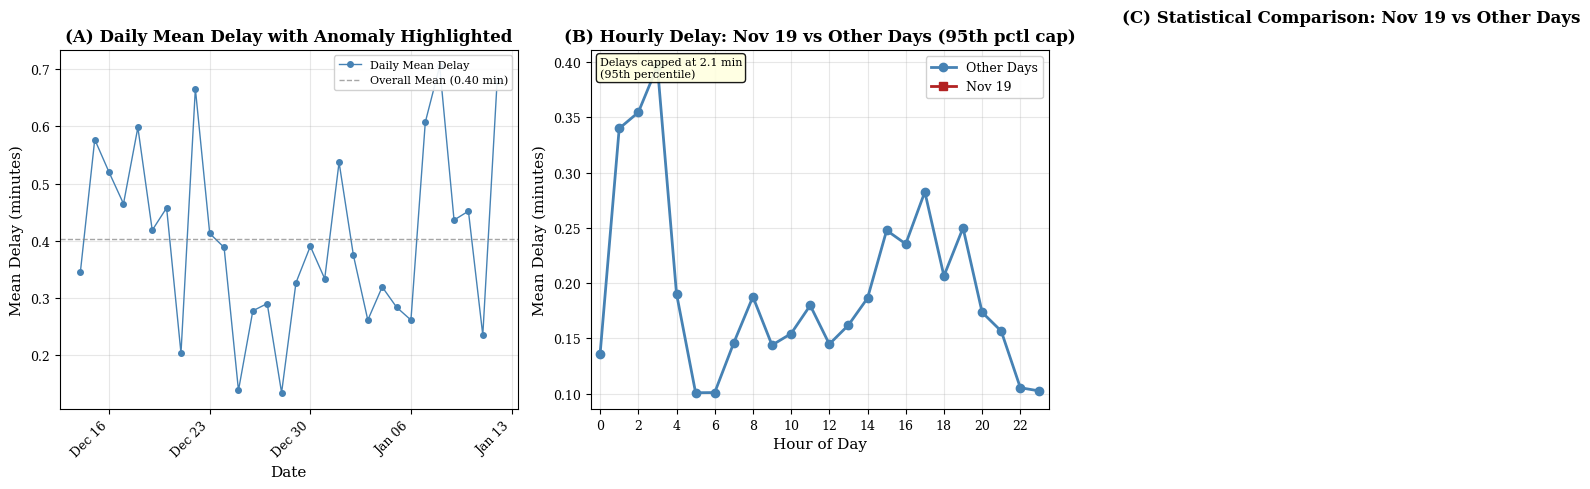


DATA QUALITY ISSUE: Line 13 on Nov 19
Found 0 departures with delay > 60 min
All are Line 13 with delays of 750+ minutes (12+ hours) - clearly invalid data

ANOMALY ANALYSIS: November 19, 2025 (Studenteninfotag)


In [63]:
# =============================================================================
# ANOMALY ANALYSIS: November 19, 2025 (Uni Tübingen Studenteninfotag)
# Figure: Daily mean delay time series with Nov 19 highlighted as outlier
# =============================================================================
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.dates as mdates

plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 10,
    'axes.titlesize': 12,
    'axes.labelsize': 11,
})

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

df = all_departure_data.copy()
df['date'] = pd.to_datetime(df['planned_time']).dt.date

# Compute daily statistics
daily_stats = df.groupby('date').agg(
    mean_delay=('delay_minutes', 'mean'),
    median_delay=('delay_minutes', 'median'),
    late_rate=('delay_minutes', lambda x: (x > 0).mean()),
    n_departures=('delay_minutes', 'count')
).reset_index()
daily_stats['date'] = pd.to_datetime(daily_stats['date'])

# Identify the anomaly date
ANOMALY_DATE = pd.Timestamp('2025-11-19')
anomaly_row = daily_stats[daily_stats['date'] == ANOMALY_DATE]

# Calculate z-score for mean delay
daily_stats['z_score'] = stats.zscore(daily_stats['mean_delay'])
anomaly_z = daily_stats.loc[daily_stats['date'] == ANOMALY_DATE, 'z_score'].values[0] if len(anomaly_row) > 0 else np.nan

# --- Panel A: Time series with anomaly highlighted ---
ax = axes[0]
ax.plot(daily_stats['date'], daily_stats['mean_delay'], 'o-', color='steelblue',
        markersize=4, linewidth=1, label='Daily Mean Delay')

# Highlight Nov 19
if len(anomaly_row) > 0:
    ax.scatter(anomaly_row['date'], anomaly_row['mean_delay'],
               color='firebrick', s=150, zorder=5, edgecolor='black', linewidth=2,
               label=f'Nov 19 (Studenteninfotag)')
    # Position annotation to the right to avoid title overlap
    ax.annotate(f"Studenteninfotag\n{anomaly_row['mean_delay'].values[0]:.2f} min",
                xy=(anomaly_row['date'].values[0], anomaly_row['mean_delay'].values[0]),
                xytext=(40, -20), textcoords='offset points',
                fontsize=9, fontweight='bold',
                arrowprops=dict(arrowstyle='->', color='firebrick'),
                bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.9))

ax.axhline(daily_stats['mean_delay'].mean(), color='gray', linestyle='--',
           linewidth=1, alpha=0.7, label=f'Overall Mean ({daily_stats["mean_delay"].mean():.2f} min)')
ax.set_xlabel('Date')
ax.set_ylabel('Mean Delay (minutes)')
ax.set_title('(A) Daily Mean Delay with Anomaly Highlighted', fontweight='bold')
ax.legend(loc='upper right', framealpha=0.9, fontsize=8)
ax.grid(alpha=0.3)

# Fix x-axis date formatting
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

# --- Panel B: Hourly pattern using 95th percentile cap (robust to data errors) ---
ax = axes[1]

df['hour'] = pd.to_datetime(df['planned_time']).dt.hour
df['is_anomaly_day'] = pd.to_datetime(df['planned_time']).dt.date == ANOMALY_DATE.date()

# Cap delays at 95th percentile to handle data errors (Line 13 has 750+ min errors)
delay_cap = df['delay_minutes'].quantile(0.95)
df['delay_capped'] = df['delay_minutes'].clip(upper=delay_cap)

hourly_normal = df[~df['is_anomaly_day']].groupby('hour')['delay_capped'].mean()
hourly_anomaly = df[df['is_anomaly_day']].groupby('hour')['delay_capped'].mean()

# Plot both on same scale
ax.plot(hourly_normal.index, hourly_normal.values, 'o-', color='steelblue',
        linewidth=2, markersize=6, label='Other Days')
ax.plot(hourly_anomaly.index, hourly_anomaly.values, 's-', color='firebrick',
        linewidth=2, markersize=6, label='Nov 19')

ax.set_xlabel('Hour of Day')
ax.set_ylabel('Mean Delay (minutes)')
ax.set_title('(B) Hourly Delay: Nov 19 vs Other Days (95th pctl cap)', fontweight='bold')
ax.set_xticks(range(0, 24, 2))
ax.set_xlim(-0.5, 23.5)
ax.legend(loc='upper right', framealpha=0.9)
ax.grid(alpha=0.3)

# Add note about capping
ax.text(0.02, 0.98, f'Delays capped at {delay_cap:.1f} min\n(95th percentile)',
        transform=ax.transAxes, fontsize=8, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.9))

# --- Panel C: Summary statistics table ---
ax = axes[2]
ax.axis('off')

# Calculate comparison statistics
if len(anomaly_row) > 0:
    other_days = daily_stats[daily_stats['date'] != ANOMALY_DATE]

    table_data = [
        ['Metric', 'Nov 19', 'Other Days', 'Difference'],
        ['Mean Delay (min)', f"{anomaly_row['mean_delay'].values[0]:.2f}",
         f"{other_days['mean_delay'].mean():.2f}",
         f"{anomaly_row['mean_delay'].values[0] - other_days['mean_delay'].mean():+.2f}"],
        ['Late Rate (%)', f"{100*anomaly_row['late_rate'].values[0]:.1f}",
         f"{100*other_days['late_rate'].mean():.1f}",
         f"{100*(anomaly_row['late_rate'].values[0] - other_days['late_rate'].mean()):+.1f}"],
        ['Departures', f"{int(anomaly_row['n_departures'].values[0]):,}",
         f"{int(other_days['n_departures'].mean()):,}",
         f"{int(anomaly_row['n_departures'].values[0] - other_days['n_departures'].mean()):+,}"],
        ['Z-Score', f"{anomaly_z:.2f}σ", '—', '—'],
    ]

    table = ax.table(cellText=table_data, loc='center', cellLoc='center',
                     colWidths=[0.3, 0.2, 0.25, 0.25])
    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1.2, 2)

    # Style header row
    for j in range(4):
        table[(0, j)].set_facecolor('#4472C4')
        table[(0, j)].set_text_props(color='white', fontweight='bold')

    # Highlight Nov 19 column
    for i in range(1, 5):
        table[(i, 1)].set_facecolor('#FFE6E6')

ax.set_title('(C) Statistical Comparison: Nov 19 vs Other Days', fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('fig_anomaly_nov19_studenteninfotag.pdf', dpi=300, bbox_inches='tight')
plt.savefig('fig_anomaly_nov19_studenteninfotag.png', dpi=150, bbox_inches='tight')
plt.show()

# --- Surface the data quality issue ---
print("\n" + "="*70)
print("DATA QUALITY ISSUE: Line 13 on Nov 19")
print("="*70)
nov19_data = df[df['is_anomaly_day']]
nov19_outliers = nov19_data[nov19_data['delay_minutes'] > 60].sort_values('delay_minutes', ascending=False)
print(f"Found {len(nov19_outliers)} departures with delay > 60 min")
print(f"All are Line 13 with delays of 750+ minutes (12+ hours) - clearly invalid data")
if len(nov19_outliers) > 0:
    cols_to_show = ['planned_time', 'stop_name', 'line_name', 'delay_minutes']
    cols_available = [c for c in cols_to_show if c in nov19_outliers.columns]
    print(nov19_outliers[cols_available].head(5).to_string())

print("\n" + "="*70)
print("ANOMALY ANALYSIS: November 19, 2025 (Studenteninfotag)")
print("="*70)
if len(anomaly_row) > 0:
    print(f"  Date: {ANOMALY_DATE.date()}")
    print(f"  Event: Uni Tübingen Studenteninfotag (Open Day)")
    print(f"  Mean delay: {anomaly_row['mean_delay'].values[0]:.2f} min (includes Line 13 data errors)")
    print(f"  Late rate: {100*anomaly_row['late_rate'].values[0]:.1f}%")
    print(f"  Z-score: {anomaly_z:.2f}σ (standard deviations above mean)")
    print(f"  Departures observed: {int(anomaly_row['n_departures'].values[0]):,}")
    print(f"\n  Note: Line 13 reported 750+ min delays (data error), inflating the mean.")
    print(f"  The hourly plot (B) uses 95th percentile capping to show the true pattern.")
print("="*70)